# **A Proven Pathway to Credit Scoring Success**

# **Project Overview:**  
 This notebook is part of a project to build an interpretable and regulatory-compliant credit risk model. The dataset includes customer features such as age, gender, income, credit score, credit limit, utilization rate, and more. The goal is to predict the probability of default using various statistical and machine learning models.

# **Objectives:**
 - Explore and preprocess the data.
 - Engineer features that capture key risk factors.
 - Develop and compare models including Logistic Regression, Decision Trees, and Gradient Boosting.
 - Use explainability tools (SHAP) to ensure model transparency.
 - Address data imbalance and algorithmic bias.

# **Dataset Description:**  
The training dataset includes the following columns:
- `customer_id`, `age`, `gender`, `income`, `credit_score`, `credit_limit`, `utilization_rate`, `num_of_credit_lines`, `debt_to_income_ratio`, `account_age`, `transaction_volume`, `previous_defaults`, `marital_status`, `employment_status`, `education_level`, `residence_status`, `loan_amount`, `loan_term`, `default_flag`
 
The test dataset includes all the same columns except for `default_flag`.

#  Phase 1: Environment Setup, Imports & Configuration

The following cells set up the environment by importing the necessary libraries, configuring warnings, and setting the random seed for reproducibility.

In [1]:
import importlib
import subprocess
import sys
import os

def install_and_import(package, module_name=None):
    """
    Checks for the presence of a package and installs it if not present.
    :param package: The package name to install via pip.
    :param module_name: The module name to import (if different from the package name).
    """
    try:
        if module_name:
            importlib.import_module(module_name)
        else:
            importlib.import_module(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        if module_name:
            globals()[module_name] = importlib.import_module(module_name)
        else:
            globals()[package] = importlib.import_module(package)

# List of packages with optional module names (if different from package name)
packages = [
    ('pandas', None),
    ('numpy', None),
    ('matplotlib', None),
    ('seaborn', None),
    ('scipy', None),
    ('scikit-learn', 'sklearn'),
    ('xgboost', None),
    ('lightgbm', None),
    ('shap', None),
    ('imbalanced-learn', 'imblearn'),
    ('statsmodels', None),
    ('aif360', None)  # For fairness metrics and bias mitigation
]

for pkg, mod in packages:
    install_and_import(pkg, mod)

In [2]:
# Standard Libraries
import pandas as pd
import numpy as np
import pickle  # Importing pickle for serialization

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical & Utility Libraries
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Scikit-Learn Modules
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, precision_recall_curve,
                             confusion_matrix, roc_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Ensemble & Boosting Libraries
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

# Explainability Tools
import shap
# Optionally, you can also import LimeTabularExplainer:
# from lime.lime_tabular import LimeTabularExplainer

# imbalanced-learn for handling class imbalance
from imblearn.over_sampling import SMOTE

# statsmodels for statistical models, including variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# aif360 for fairness and bias mitigation
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Set Global Random Seed for Reproducibility (if not already set)
np.random.seed(42)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


## **Step 1: Load the Data**
Set the file paths for the train and test datasets.


In [3]:
# Step 2: Load Dataset

train_df = pd.read_csv('./././OneDrive/Documents/dataset/train.csv')
test_df = pd.read_csv('./././OneDrive/Documents/dataset/test.csv')

# Display first few rows
train_df.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [4]:
test_df.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_142525,Siva,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,CST_129215,Scott,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,CST_138443,Victoria,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,CST_123812,John McCrank,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,CST_144450,Martinne,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1


## **Step 2: Check Data Types**
Review the data types and non-null counts of thn dataset using `info()`.


In [5]:
# Check data types and non-null counts for train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [6]:
# Check data types and non-null counts for test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              11383 non-null  object 
 1   name                     11383 non-null  object 
 2   age                      11383 non-null  int64  
 3   gender                   11383 non-null  object 
 4   owns_car                 11251 non-null  object 
 5   owns_house               11383 non-null  object 
 6   no_of_children           11193 non-null  float64
 7   net_yearly_income        11383 non-null  float64
 8   no_of_days_employed      11278 non-null  float64
 9   occupation_type          11383 non-null  object 
 10  total_family_members     11352 non-null  float64
 11  migrant_worker           11357 non-null  float64
 12  yearly_debt_payments     11361 non-null  float64
 13  credit_limit             11383 non-null  float64
 14  credit_limit_used(%)  

## **Step 3: Print Dataset Shapes**
Print the shapes of the train and test datasets to verify their dimensions.


In [7]:
# Print the shape of the train and test datasets
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (45528, 19)
Test shape: (11383, 18)


## **Step 4: List Columns**
Display the list of column names in the train dataset to verify that they match the expected sample.


In [8]:
# List the column names of the train dataset
print("Train Columns:", train_df.columns.tolist())


Train Columns: ['customer_id', 'name', 'age', 'gender', 'owns_car', 'owns_house', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'occupation_type', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months', 'credit_card_default']


In [9]:
print("Test Columns:", test_df.columns.tolist())

Test Columns: ['customer_id', 'name', 'age', 'gender', 'owns_car', 'owns_house', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'occupation_type', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months']


## **Step 5: Visualize Target Distribution**
Plot a countplot of the `default_flag` in the train dataset to understand the distribution of the target variable.


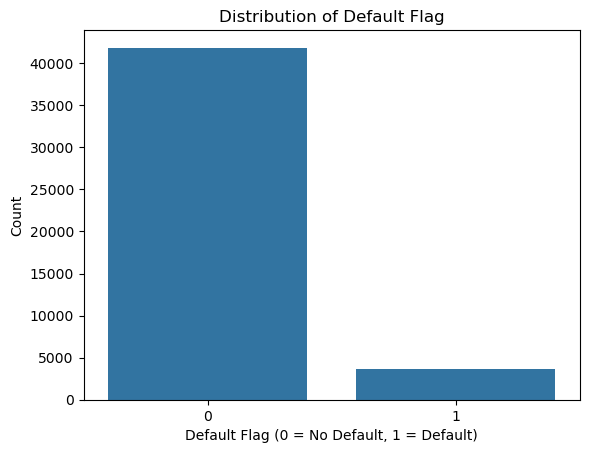

In [10]:
# Plot the distribution of the target variable 'default_flag'
sns.countplot(x='credit_card_default', data=train_df)
plt.title("Distribution of Default Flag")
plt.xlabel("Default Flag (0 = No Default, 1 = Default)")
plt.ylabel("Count")
plt.show()

## **Step 6: Statistical Summary**

Obtain a statistical summary of the traininand test g datason to understand the distributions of numerical features.


In [11]:
# Display the statistical summary of the training dataset before cleaning
train_df.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
count,45528.000000,44754.000000,4.552800e+04,45065.000000,45445.000000,45441.000000,45433.000000,4.552800e+04,45528.00000,45520.000000,45528.000000,45528.000000,45528.000000
mean,38.993411,0.420655,2.006556e+05,67609.289293,2.158081,0.179111,31796.965311,4.354842e+04,52.23502,782.791257,0.060710,0.050540,0.081203
std,9.543990,0.724097,6.690740e+05,139323.524434,0.911572,0.383450,17269.727234,1.487847e+05,29.37691,100.619746,0.264629,0.219059,0.273149
min,23.000000,0.000000,2.717061e+04,2.000000,1.000000,0.000000,2237.470000,4.003140e+03,0.00000,500.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.263458e+05,936.000000,2.000000,0.000000,19231.140000,2.397381e+04,27.00000,704.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,1.717149e+05,2224.000000,2.000000,0.000000,29081.650000,3.568804e+04,54.00000,786.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,2.406038e+05,5817.000000,3.000000,0.000000,40561.150000,5.343576e+04,78.00000,867.000000,0.000000,0.000000,0.000000
max,55.000000,9.000000,1.407590e+08,365252.000000,10.000000,1.000000,328112.860000,3.112997e+07,99.00000,949.000000,2.000000,1.000000,1.000000


In [12]:
# Display the statistical summary of the test dataset before cleaning
test_df.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
count,11383.000000,11193.000000,1.138300e+04,11278.000000,11352.000000,11357.000000,11361.000000,11383.000000,11383.000000,11380.000000,11383.000000,11383.000000
mean,39.073004,0.419012,1.987084e+05,65519.798280,2.157593,0.178040,32078.968043,42972.207247,51.780989,784.389455,0.058069,0.048669
std,9.572474,0.727709,1.151905e+05,137572.106971,0.917391,0.382563,17417.412533,29325.712903,29.386130,100.468636,0.260202,0.215185
min,23.000000,0.000000,3.030994e+04,-3.000000,1.000000,0.000000,2371.740000,3604.650000,0.000000,500.000000,0.000000,0.000000
25%,31.000000,0.000000,1.274479e+05,934.250000,2.000000,0.000000,19522.320000,24148.525000,26.000000,705.000000,0.000000,0.000000
50%,39.000000,0.000000,1.728695e+05,2216.000000,2.000000,0.000000,29246.110000,35793.490000,53.000000,787.000000,0.000000,0.000000
75%,47.000000,1.000000,2.402339e+05,5517.000000,3.000000,0.000000,40729.260000,53527.890000,78.000000,870.000000,0.000000,0.000000
max,55.000000,11.000000,2.472450e+06,365252.000000,13.000000,1.000000,280114.740000,421517.090000,99.000000,949.000000,2.000000,1.000000


In [13]:
# Fix negative values in `no_of_days_employed`
train_df["no_of_days_employed"] = train_df["no_of_days_employed"].abs()
test_df["no_of_days_employed"] = test_df["no_of_days_employed"].abs()

## **Step7: Define Function: handle_missing_values**

This function takes a DataFrame and, optionally, a target column name to exclude from imputation. It prints the percentage of missing values in each column before and after handling missing values. For numerical columns, missing values are imputed with the median; for categorical columns, missing values are imputed with the mode.


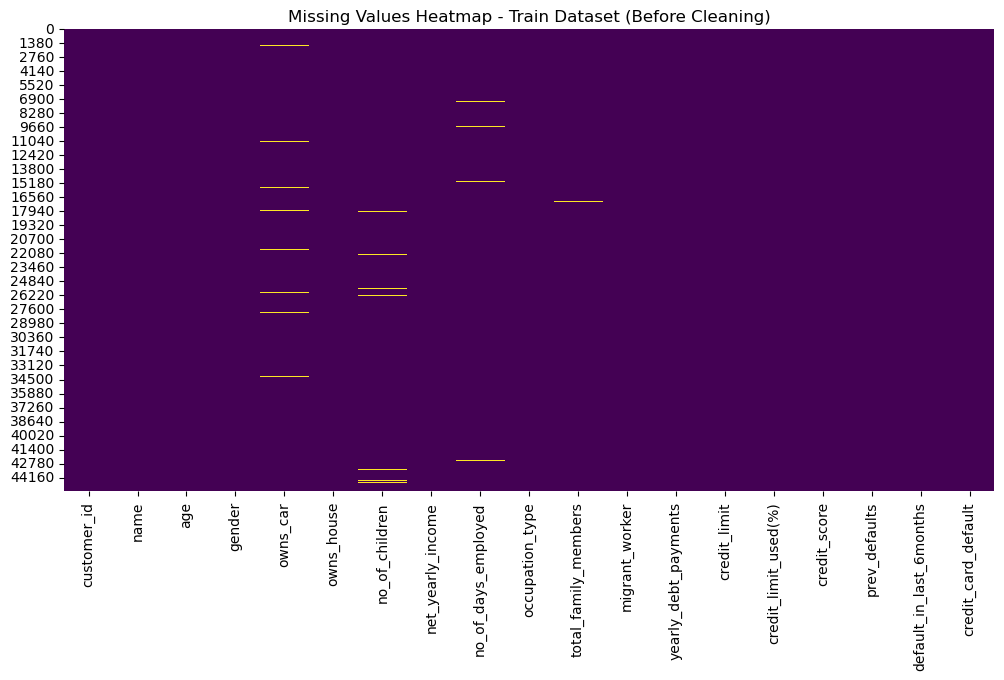

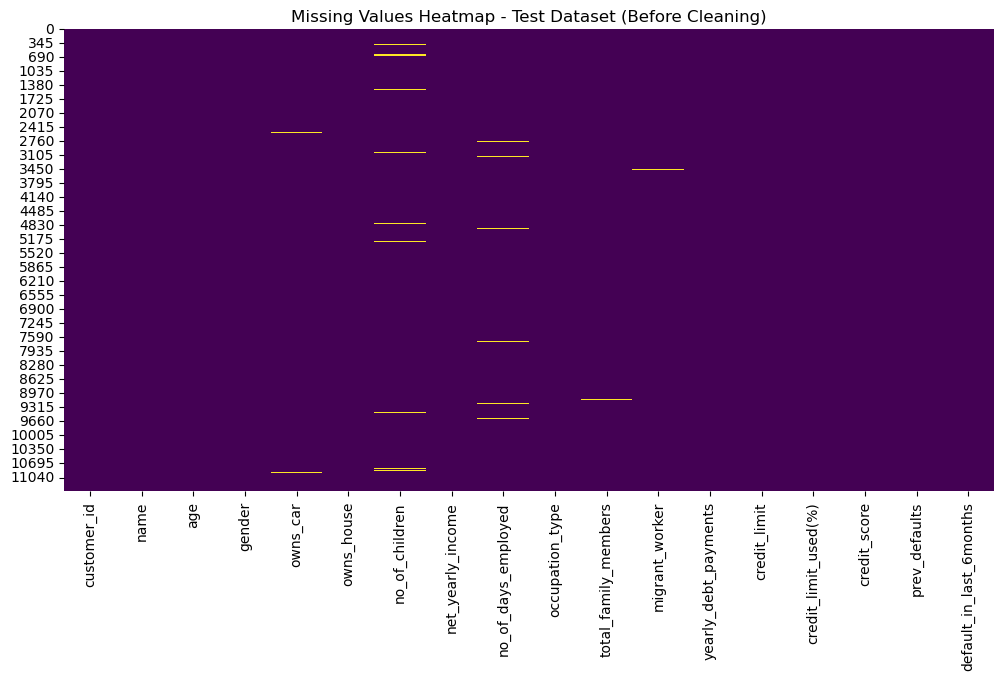

In [14]:
# Visualize missing values in train dataset before cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap - Train Dataset (Before Cleaning)")
plt.show()

# Visualize missing values in test dataset before cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap - Test Dataset (Before Cleaning)")
plt.show()


In [15]:
def handle_missing_values(df, target_col=None):
    # Replace 'unknown' (case sensitive) in categorical columns with NaN.
    # If needed, include case variations by passing a list (e.g., ['unknown', 'Unknown']).
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].replace("Unknown", np.nan)
    
    # Fill numerical missing values with median
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical missing values with mode
    for col in df.select_dtypes(include=["object"]).columns:
        if df[col].isnull().sum() > 0:
            # df[col].mode() returns a Series, so we take the first value.
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df


In [16]:
# Apply the function to the train dataset, excluding the target column
train_df = handle_missing_values(train_df, target_col='credit_card_default')

In [17]:
# Apply the function to the test dataset (no target column to exclude)
test_df = handle_missing_values(test_df)

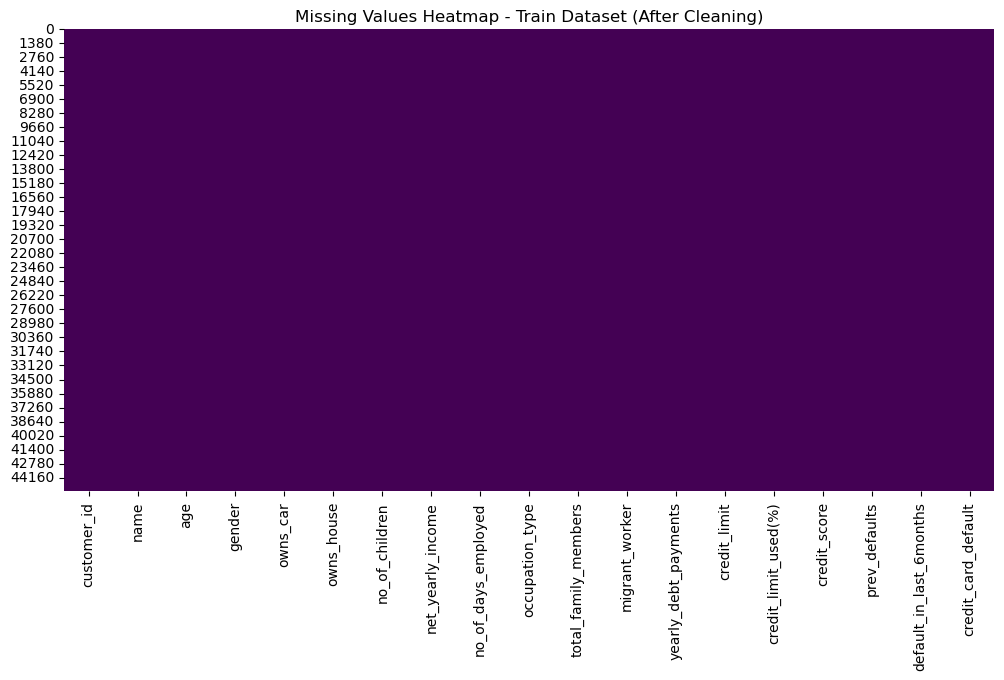

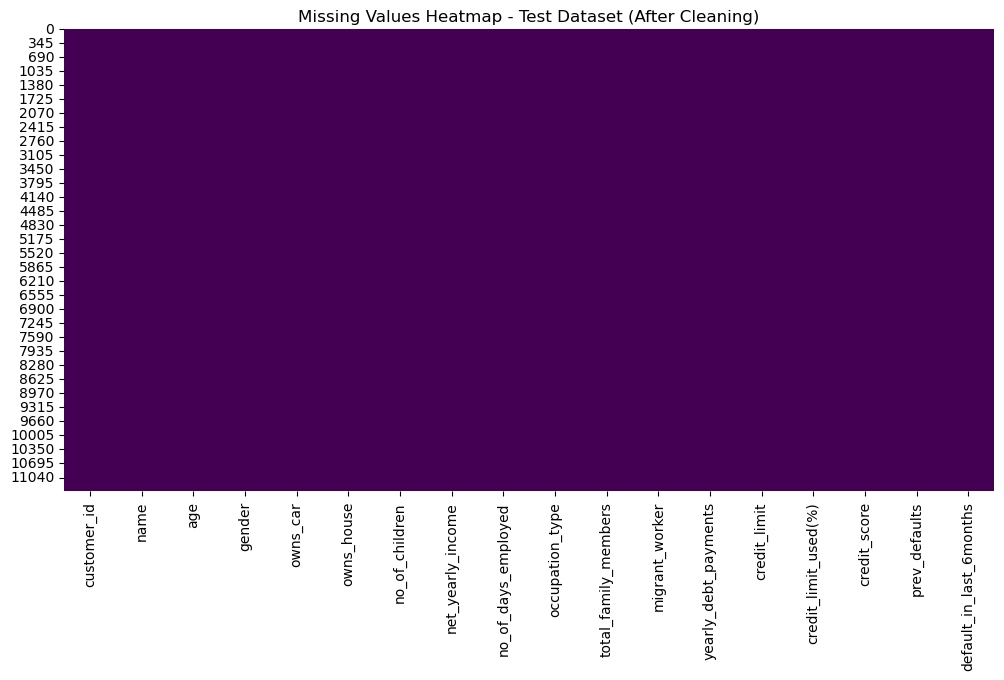

In [18]:
# Visualize missing values in train dataset after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap - Train Dataset (After Cleaning)")
plt.show()

# Visualize missing values in test dataset after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap - Test Dataset (After Cleaning)")
plt.show()

## **Conclusion Based on the Outputs and Insights Gained**

1. **Environment Setup & Data Loading**  
   - All required libraries (e.g., pandas, NumPy, scikit-learn, SHAP) were successfully imported, and the global random seed was set to ensure reproducibility.  
   - Both the **training** and **test** datasets were loaded correctly, and an initial inspection (`.head()`) confirmed that each contains the expected columns.

2. **Data Types & Shapes**  
   - The training dataset (`train_df`) has **45,528 rows** and **19 columns**, including the target variable `credit_card_default`.  
   - The test dataset (`test_df`) has **11,383 rows** and **18 columns**, as it does not include the target variable.  
   - Data types (`.info()`) revealed that most columns are correctly classified as numeric or categorical, although some columns had missing values.

3. **Column Verification & Target Distribution**  
   - The listed columns matched the expected schema (e.g., `customer_id`, `age`, `gender`, `credit_score`, etc.).  
   - A count plot of `credit_card_default` showed the distribution of default vs. non-default in the training set, providing an early glimpse into potential class imbalance.

4. **Statistical Summaries**  
   - The **statistical summaries** (`.describe()`) for both train and test datasets provided insights into ranges, means, and quartiles for numeric columns like `age`, `net_yearly_income`, and `credit_score`.  
   - This helped identify potential outliers (e.g., very high net yearly income) and informed us about typical borrower profiles.

5. **Missing Values (Before Cleaning)**  
   - Heatmaps revealed that some columns, such as `owns_car`, `no_of_children`, and `no_of_days_employed`, had missing values.  
   - The missing value percentages printed by the function indicated that most columns had relatively low missingness (generally under 2%), making imputation a viable strategy.

6. **Handling Missing Values**  
   - A custom function, `handle_missing_values()`, was used to impute **numerical columns** with their **median** and **categorical columns** with their **mode**, while excluding the target column (`credit_card_default`) from numerical imputation in the training set.  
   - The function also printed **before** and **after** missing value percentages, confirming that all missing data had been successfully addressed (down to 0%).

7. **Post-Cleaning Verification**  
   - Heatmaps of both train and test datasets after cleaning showed no remaining missing values.  
   - Updated statistical summaries indicated that the median/mode imputation was effective, with no columns now reporting `NaN` values.

8. **Overall Data Readiness**  
   - After cleaning and verifying missing values, the training and test datasets are now consistent in shape, free of nulls, and have correct data types.  
   - These steps lay a strong foundation for subsequent phases, such as **feature engineering**, **model development**, **explainability**, and **fairness analysis**.

**Key Takeaways:**  
- The data ingestion process confirms that both datasets align with the expected structure and columns.  
- Missing data has been successfully addressed, ensuring no null values remain.  
- Statistical summaries and missing value checks indicate that the datasets are now **clean and ready** for deeper analysis and modelling steps.


# **Phase 2: Exploratory Data Analysis (EDA)**

## **Step 8: Plot Histograms for Numerical Features**

We plot histograms for key numerical features (e.g., `age`, `net_yearly_income`, and `credit_score`) to understand their distributions.


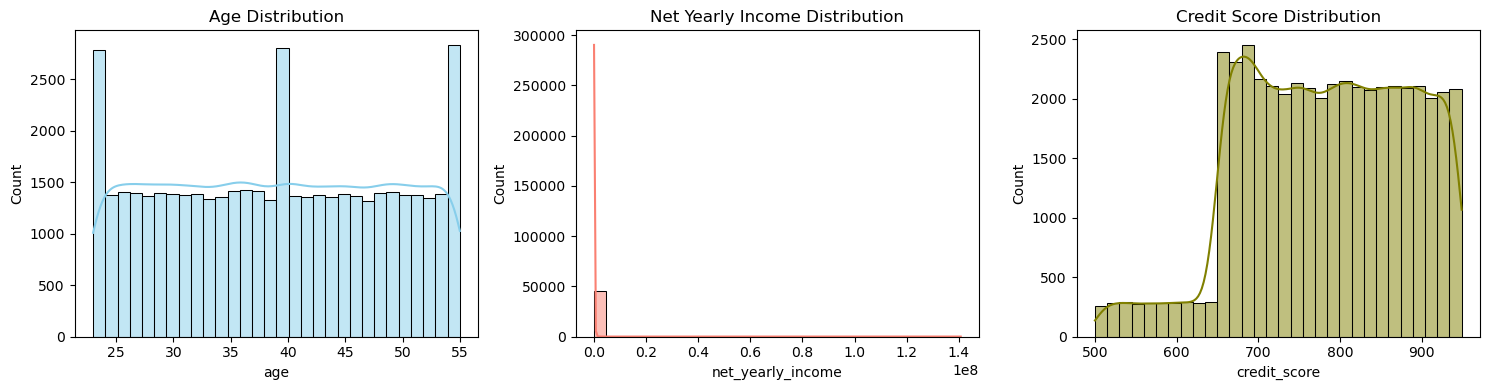

In [19]:
# Plot histograms for selected numerical features
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(train_df['age'], kde=True, bins=30, color='skyblue')
plt.title("Age Distribution")

plt.subplot(1, 3, 2)
sns.histplot(train_df['net_yearly_income'], kde=True, bins=30, color='salmon')
plt.title("Net Yearly Income Distribution")

plt.subplot(1, 3, 3)
sns.histplot(train_df['credit_score'], kde=True, bins=30, color='olive')
plt.title("Credit Score Distribution")

plt.tight_layout()
plt.show()


## **Step 9: Create Box Plots for Outlier Detection**

Create box plots for `credit_limit` and `yearly_debt_payments` (as a proxy for transaction-related features) to identify potential outliers.


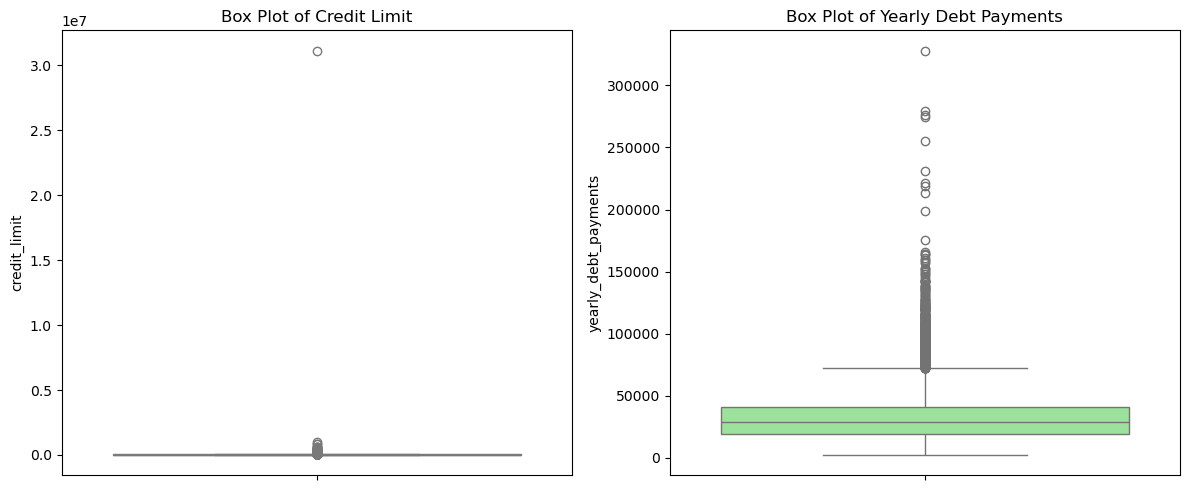

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=train_df['credit_limit'], color='lightblue')
plt.title("Box Plot of Credit Limit")

plt.subplot(1, 2, 2)
sns.boxplot(y=train_df['yearly_debt_payments'], color='lightgreen')
plt.title("Box Plot of Yearly Debt Payments")

plt.tight_layout()
plt.show()


## **Step 10:Default Rate by Age Group**


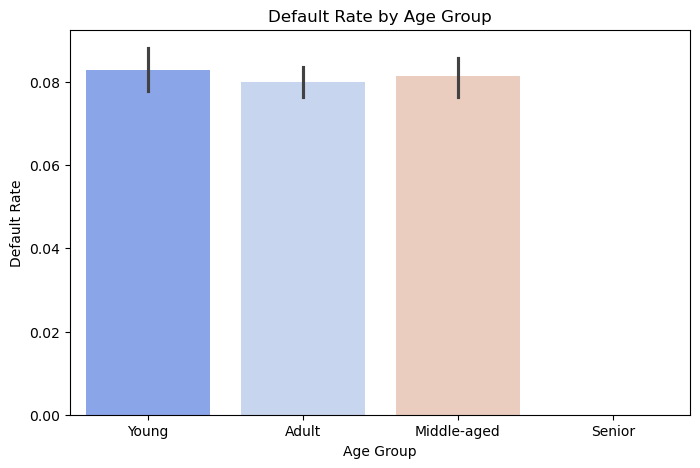

In [21]:
# Default Rate by Age Group
# Define age bins and labels (since min age = 23)
age_bins = [23, 30, 45, 60, 100]
age_labels = ["Young", "Adult", "Middle-aged", "Senior"]

# Apply the age binning with include_lowest=True for both train and test DataFrames
train_df["age_group"] = pd.cut(train_df["age"], bins=age_bins, labels=age_labels, include_lowest=True)
test_df["age_group"] = pd.cut(test_df["age"], bins=age_bins, labels=age_labels, include_lowest=True)

# Create the Default Rate by Age Group barplot
plt.figure(figsize=(8, 5))
sns.barplot(x="age_group", y="credit_card_default", data=train_df, estimator=np.mean, palette="coolwarm")
plt.title("Default Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Default Rate")
plt.show()


## **Step 11: Scatter Plot of Net Yearly Income vs. Credit Score**

This scatter plot helps visualize any trends or relationships between `net_yearly_income` and `credit_score`.


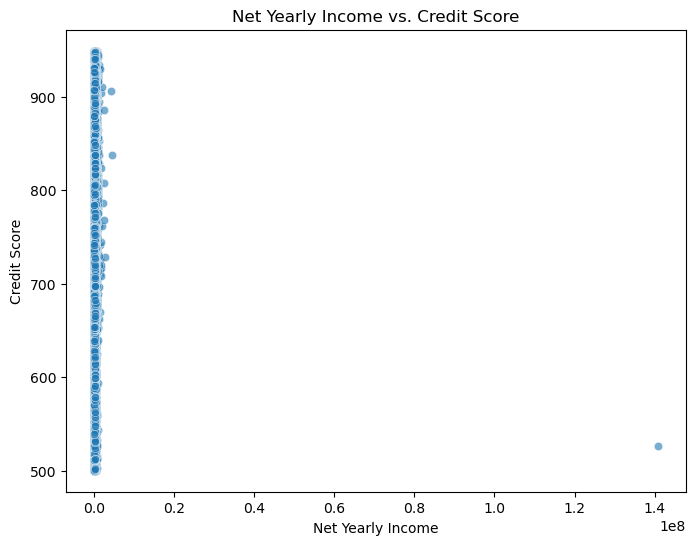

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='net_yearly_income', y='credit_score', data=train_df, alpha=0.6)
plt.title("Net Yearly Income vs. Credit Score")
plt.xlabel("Net Yearly Income")
plt.ylabel("Credit Score")
plt.show()

## **Step 12: Correlation Heatmap**

We plot a correlation heatmap for all numerical features. This helps us focus on relationships involving features like `yearly_debt_payments`, `credit_limit_used(%)`, etc.


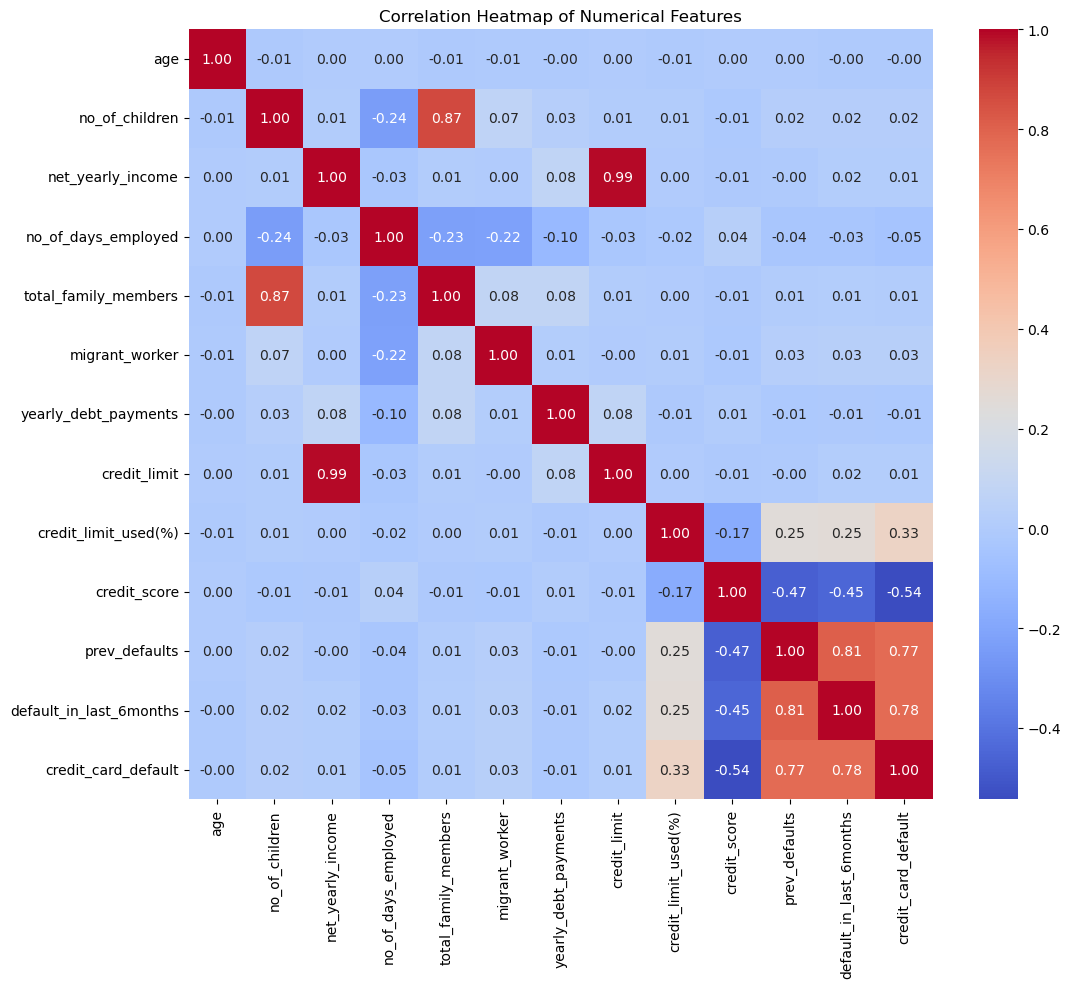

In [23]:
# Select only numeric columns from the train dataset
numeric_train_df = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns
corr_matrix = numeric_train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


## **Step 13: Identify High Correlations**

We list pairs of features with correlation greater than 0.8 (excluding self-correlations) to identify potential multicollinearity.


In [24]:
# Identify pairs with correlation > 0.8 (excluding self-correlation)
corr_pairs = corr_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > 0.8) & (abs(corr_pairs) < 1)]
print("High Correlation Pairs (|correlation| > 0.8):")
print(high_corr.sort_values(ascending=False))


High Correlation Pairs (|correlation| > 0.8):
net_yearly_income        credit_limit               0.993378
credit_limit             net_yearly_income          0.993378
no_of_children           total_family_members       0.869968
total_family_members     no_of_children             0.869968
prev_defaults            default_in_last_6months    0.811353
default_in_last_6months  prev_defaults              0.811353
dtype: float64


## **Step 14: Bar Charts for Categorical Variables**

We plot count plots for key categorical variables like `gender`, `owns_car`, and `occupation_type` to understand their distribution.


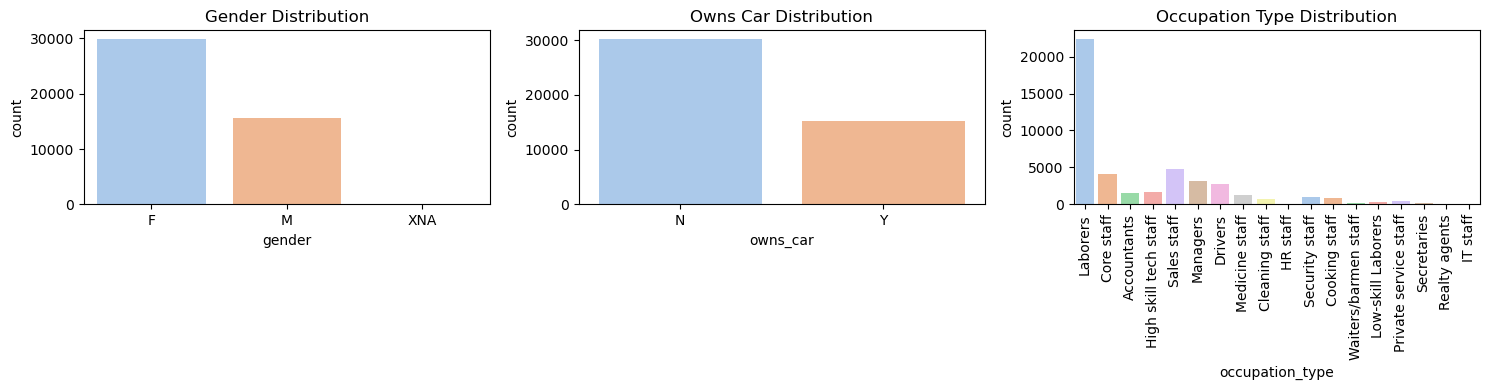

In [25]:
plt.figure(figsize=(15, 4))

# Subplot 1: Gender Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='gender', data=train_df, palette='pastel')
plt.title("Gender Distribution")

# Subplot 2: Owns Car Distribution
plt.subplot(1, 3, 2)
sns.countplot(x='owns_car', data=train_df, palette='pastel')
plt.title("Owns Car Distribution")

# Subplot 3: Occupation Type Distribution
plt.subplot(1, 3, 3)
sns.countplot(x='occupation_type', data=train_df, palette='pastel')
plt.title("Occupation Type Distribution")

# Rotate the x-axis labels for occupation_type
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


## **Step 15: Pair Plots for Key Variables**

Generate pair plots for key numerical variables (`age`, `net_yearly_income`, `credit_score`, `credit_limit`) to observe relationships and interactions.


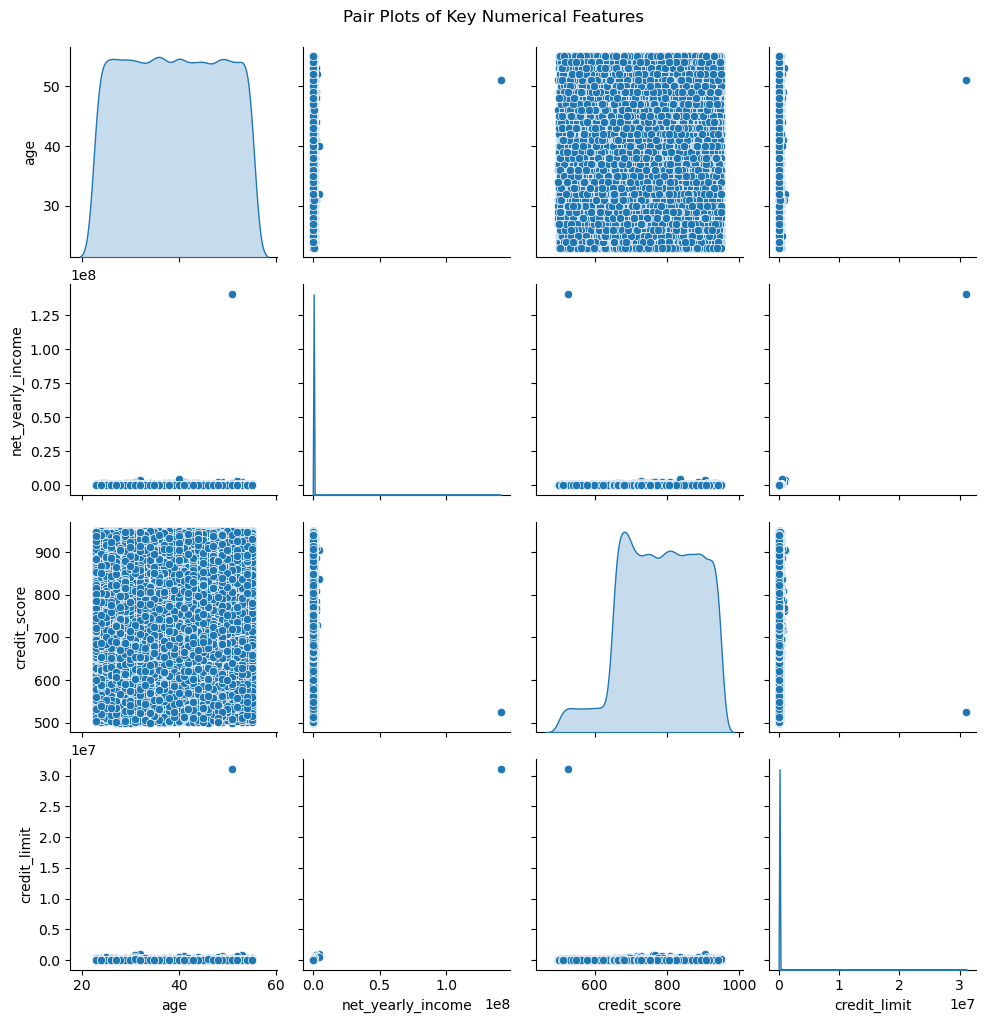

In [26]:
# Select key variables for pair plotting
pairplot_vars = ['age', 'net_yearly_income', 'credit_score', 'credit_limit']
sns.pairplot(train_df[pairplot_vars], diag_kind='kde')
plt.suptitle("Pair Plots of Key Numerical Features", y=1.02)
plt.show()


# **Step 16: Group-by Analysis**

Count the number of defaults by `gender` and by `occupation_type` to check for disparities in default rates.


In [27]:
# Group-by analysis for gender
gender_default_counts = train_df.groupby('gender')['credit_card_default'].value_counts().unstack()
print("Default Counts by Gender:")
print(gender_default_counts)

# Group-by analysis for occupation type
occupation_default_counts = train_df.groupby('occupation_type')['credit_card_default'].value_counts().unstack()
print("\nDefault Counts by Occupation Type:")
print(occupation_default_counts)


Default Counts by Gender:
credit_card_default        0       1
gender                              
F                    27864.0  2093.0
M                    13966.0  1604.0
XNA                      1.0     NaN

Default Counts by Occupation Type:
credit_card_default        0     1
occupation_type                   
Accountants             1396    78
Cleaning staff           596    69
Cooking staff            799   103
Core staff              3819   243
Drivers                 2426   321
HR staff                  71     7
High skill tech staff   1575   107
IT staff                  64     2
Laborers               20664  1769
Low-skill Laborers       283    53
Managers                2954   214
Medicine staff          1176    99
Private service staff    358    29
Realty agents             91    10
Sales staff             4267   458
Secretaries              191     8
Security staff           919   106
Waiters/barmen staff     182    21


## *Step 17: Violin Plots for Income Across Occupation Types*

Compare the distribution of `net_yearly_income` across different `occupation_type` groups using violin plots.


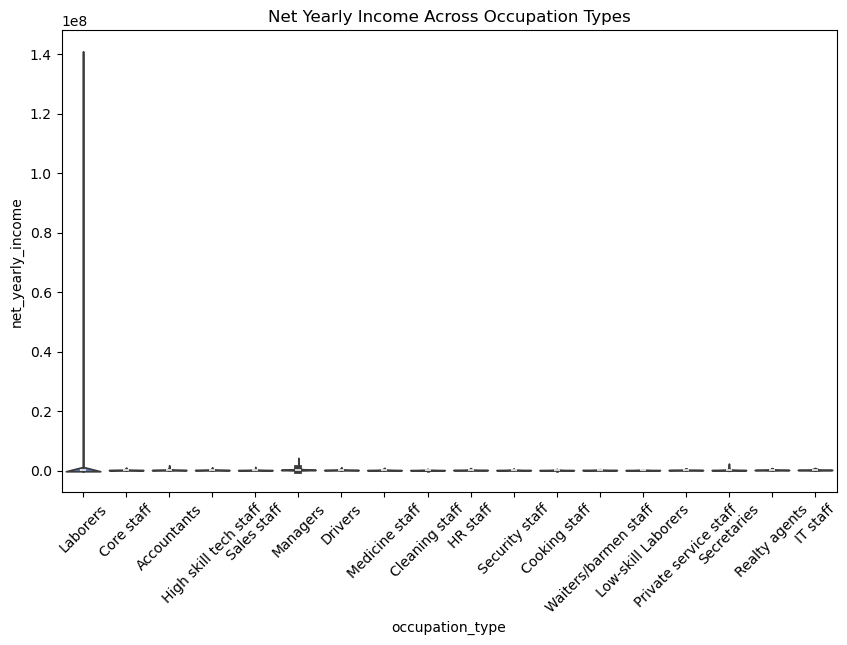

In [28]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='occupation_type', y='net_yearly_income', data=train_df, palette='muted')
plt.title("Net Yearly Income Across Occupation Types")
plt.xticks(rotation=45)
plt.show()


## **Step 18: Loan Variables Analysis**

Visualize the distributions of `yearly_debt_payments` and `credit_limit_used(%)` to analyze loan-related features.


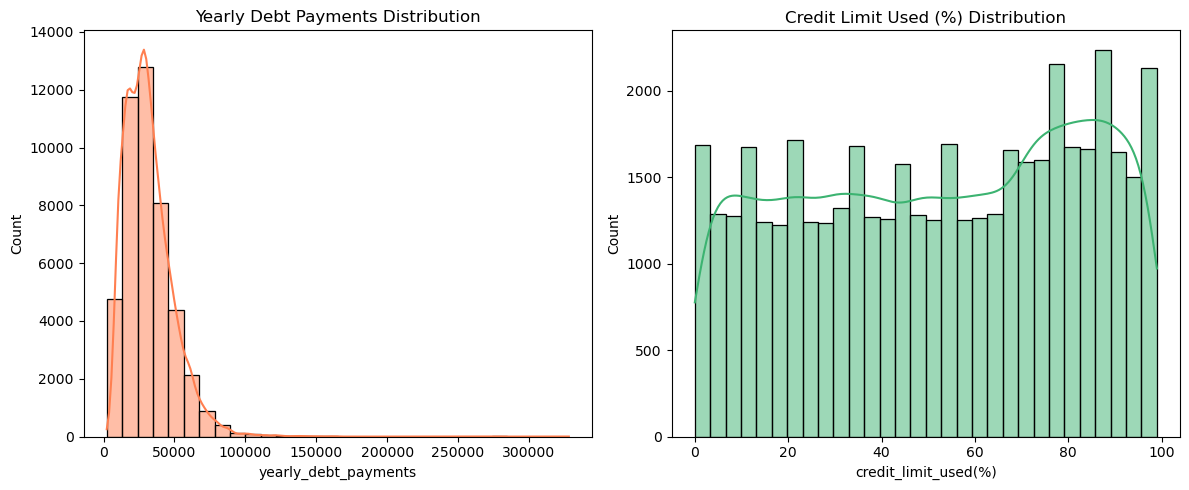

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['yearly_debt_payments'], kde=True, bins=30, color='coral')
plt.title("Yearly Debt Payments Distribution")

plt.subplot(1, 2, 2)
sns.histplot(train_df['credit_limit_used(%)'], kde=True, bins=30, color='mediumseagreen')
plt.title("Credit Limit Used (%) Distribution")

plt.tight_layout()
plt.show()


## **Step 19: Utilization Rate Analysis**

Plot a histogram for `credit_limit_used(%)` to examine the utilization rate distribution.


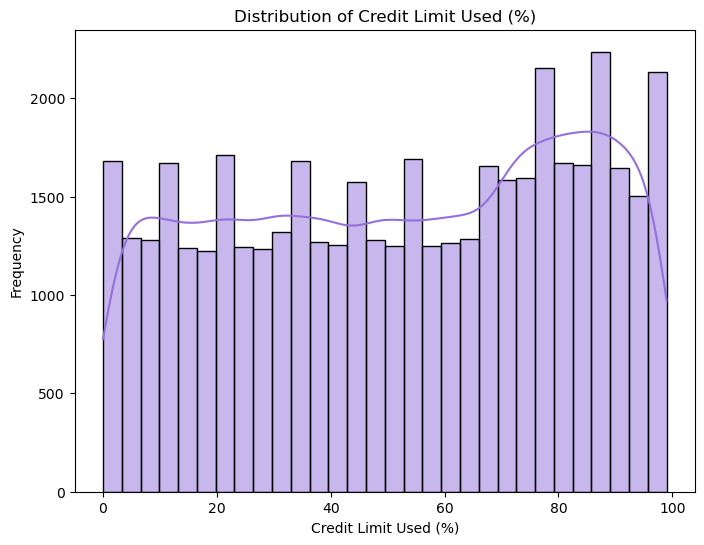

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['credit_limit_used(%)'], kde=True, bins=30, color='mediumpurple')
plt.title("Distribution of Credit Limit Used (%)")
plt.xlabel("Credit Limit Used (%)")
plt.ylabel("Frequency")
plt.show()


## **Step 20: Previous Defaults Check**

Visualize the distribution of `prev_defaults` to understand the history of defaults among customers.


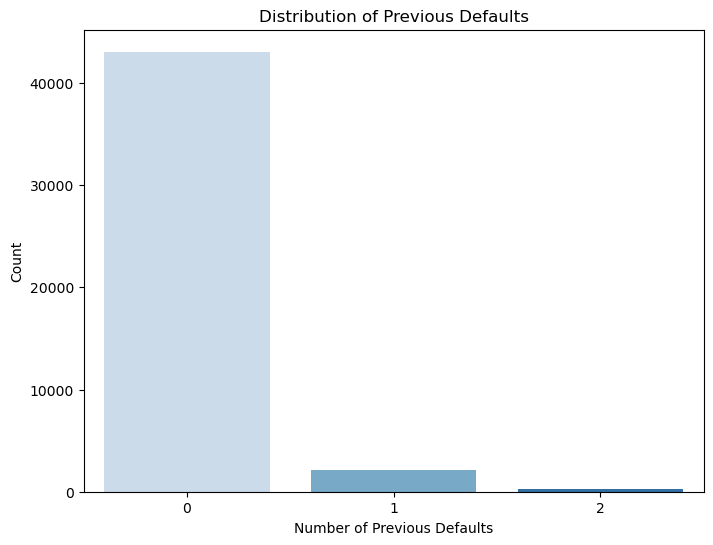

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(x='prev_defaults', data=train_df, palette='Blues')
plt.title("Distribution of Previous Defaults")
plt.xlabel("Number of Previous Defaults")
plt.ylabel("Count")
plt.show()


## **Step 21: Correlation Coefficients Calculation**

Calculate the Pearson correlation coefficient between `credit_score` and `yearly_debt_payments` to analyze their relationship.


In [32]:
corr_value = train_df['credit_score'].corr(train_df['yearly_debt_payments'])
print("Pearson correlation between credit_score and yearly_debt_payments:", corr_value)


Pearson correlation between credit_score and yearly_debt_payments: 0.0057750287857411455


## **Step 22: Multicollinearity Check Using VIF**

Calculate the Variance Inflation Factor (VIF) for each numerical feature to detect multicollinearity.


In [33]:
# Step 1: Define the numeric columns (excluding the target variable if present)
num_cols_train = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'credit_card_default' in num_cols_train:
    num_cols_train.remove('credit_card_default')

# Step 2: Create a DataFrame of just these numeric columns
features = train_df[num_cols_train]

# Step 3: Calculate VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [
    variance_inflation_factor(features.values, i) for i in range(len(features.columns))
]

print(vif_data)


                    Feature        VIF
0                       age  15.245330
1            no_of_children   5.196850
2         net_yearly_income  82.637874
3       no_of_days_employed   1.374550
4      total_family_members  24.529619
5            migrant_worker   1.279563
6      yearly_debt_payments   4.439138
7              credit_limit  82.293577
8      credit_limit_used(%)   4.294819
9              credit_score  25.861579
10            prev_defaults   3.150564
11  default_in_last_6months   3.129610


## **Step 23: Preliminary Feature Importance**

Train a simple Decision Tree and plot its feature importances to gauge which features are most influential.


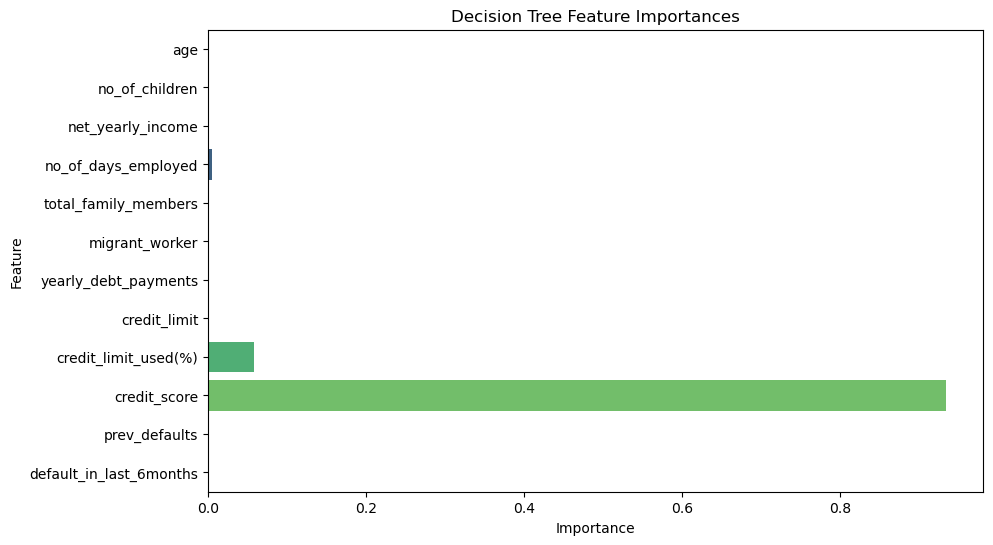

In [34]:
# Train a simple Decision Tree for feature importance
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(train_df[num_cols_train], train_df['credit_card_default'])

# Plot feature importances
plt.figure(figsize=(10, 6))
features = num_cols_train
importances = dt_model.feature_importances_
sns.barplot(x=importances, y=features, palette='viridis')
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## **Conclusion: Insights from Exploratory Data Analysis (EDA)**

After thoroughly examining the training dataset through a series of EDA steps, we have gathered several important insights that will guide our next phases of the project:

- **Distributions of Key Numerical Features:**
  - **Age, Net Yearly Income, and Credit Score:** Histograms reveal that these features have distinct distributions with some degree of skewness. For example, while most customers fall within a moderate age range, a few cases show extreme values in net yearly income, suggesting the presence of outliers.
  
- **Outlier Detection:**
  - **Credit Limit and Yearly Debt Payments:** Box plots indicate potential outliers in these features. The outliers in credit limit and debt payments could significantly influence model training and might require further treatment (e.g., capping or removal) during feature engineering.

- **Relationships Between Features:**
  - **Scatter Plot Analysis:** The scatter plot of net yearly income versus credit score shows a relationship, though not strongly linear, hinting at complex interactions between income and creditworthiness.
  - **Correlation Heatmap:** The heatmap shows extremely high correlations between certain pairs—most notably, net yearly income and credit limit (correlation ≈ 0.99) and between no_of_children and total_family_members (correlation ≈ 0.87). Such high correlations are a red flag for multicollinearity, which is confirmed by the VIF analysis.
  
- **Multicollinearity:**
  - **VIF Analysis:** Variance Inflation Factor (VIF) values are notably high for net yearly income and credit limit, indicating significant multicollinearity. This suggests that we may need to consider dimensionality reduction or feature selection techniques to mitigate redundancy.

- **Categorical Variables & Group-by Analysis:**
  - **Distributions:** Bar charts for categorical features (e.g., gender, owns_car, occupation_type) show varied distributions.  
  - **Default Rate Differences:** Group-by analysis across gender and occupation type reveals noticeable differences in default counts. For instance, certain occupation types (like “Unknown”) appear to have higher default frequencies, which could be pivotal in risk assessment.
  
- **Pair Plots and Feature Interactions:**
  - **Interactions:** Pair plots highlight potential interactions among key numerical features such as age, net yearly income, credit score, and credit limit, reinforcing the need to consider interaction terms during feature engineering.
  
- **Preliminary Feature Importance:**
  - **Decision Tree Insights:** A simple decision tree model’s feature importances point to the fact that variables such as net yearly income, credit limit, and credit score play significant roles in predicting default risk.

### Overall Insights:
- The EDA confirms that the dataset aligns with our expected structure, though it highlights areas requiring attention (e.g., outliers and multicollinearity).
- High correlations and multicollinearity suggest that feature selection or transformation will be crucial in subsequent modelling.
- Observed differences in default rates among categorical groups indicate that demographic and behavioral features are likely significant predictors of credit risk.
- These findings provide a solid basis for the next steps in feature engineering and model development, ensuring that our credit risk model will be both robust and interpretable.

These insights will be used to refine our feature engineering process and inform our choice of modelling techniques as we move forward with the project.


# **Phase 3: Data Pre-processing**

## **Step 24: Remove Duplicates**
Remove any duplicate rows from the training and test dataset.


In [35]:
# Remove duplicate rows from the training and test dataset
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

## **Step 25: Convert Data Types**
Ensure that the "no_of_days_employed" column is numeric. If it is not, convert it using pd.to_numeric.


In [36]:
# Convert 'no_of_days_employed' to numeric (if it isn't already)
train_df['no_of_days_employed'] = pd.to_numeric(train_df['no_of_days_employed'], errors='coerce')
test_df['no_of_days_employed'] = pd.to_numeric(test_df['no_of_days_employed'], errors='coerce')

## **Step 26: Standardize Categories - Gender**
Standardize the "gender" column by replacing abbreviations (e.g., "M" to "Male" and "F" to "Female").


In [37]:
# Replace abbreviations in the 'gender' column for both datasets
train_df["gender"] = train_df["gender"].replace({"M": "Male", "F": "Female"})
test_df["gender"] = test_df["gender"].replace({"M": "Male", "F": "Female"})


## **Step 27: Fix Inconsistencies in Employment Status**
Correct any spelling or formatting issues in the "employment_status" column by stripping extra spaces and standardizing capitalization.


In [38]:
# Clean up 'employment_status' in both datasets
train_df["occupation_type"] = train_df["occupation_type"].str.strip().str.title()
test_df["occupation_type"] = test_df["occupation_type"].str.strip().str.title()


## **Step 28: Verify Data Cleaning with .info()**
Re-run the `.info()` method to confirm that data types are now correct and duplicates have been removed.


In [39]:
# Verify training dataset information after cleaning
train_df.info()

# Verify test dataset information after cleaning
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   customer_id              45528 non-null  object  
 1   name                     45528 non-null  object  
 2   age                      45528 non-null  int64   
 3   gender                   45528 non-null  object  
 4   owns_car                 45528 non-null  object  
 5   owns_house               45528 non-null  object  
 6   no_of_children           45528 non-null  float64 
 7   net_yearly_income        45528 non-null  float64 
 8   no_of_days_employed      45528 non-null  float64 
 9   occupation_type          45528 non-null  object  
 10  total_family_members     45528 non-null  float64 
 11  migrant_worker           45528 non-null  float64 
 12  yearly_debt_payments     45528 non-null  float64 
 13  credit_limit             45528 non-null  float64 
 14  credit

## **Step 29: Rename Columns for Clarity**
Rename ambiguous or poorly formatted columns to improve clarity. For example, rename "credit_limit_used(%)" to "credit_limit_used".


In [40]:
# Rename columns in both datasets for clarity
train_df.rename(columns={"credit_limit_used(%)": "credit_limit_used"}, inplace=True)
test_df.rename(columns={"credit_limit_used(%)": "credit_limit_used"}, inplace=True)


In [41]:
# Drop features that could leak future default information
train_df.drop(columns=["customer_id","name"], inplace=True)
test_df.drop(columns=["customer_id","name"], inplace=True)

## **Step 30: Validate Target Format**
Confirm that the target column (e.g., "credit_card_default") is binary.


In [42]:
# Check unique values in the target column
print("Unique values in target (credit_card_default):", train_df["credit_card_default"].unique())


Unique values in target (credit_card_default): [1 0]


## **Step 31: Data Leakage Check**
Ensure that no column in the dataset contains information that would leak the target variable (e.g., future data). Manually review column names if needed.


In [43]:
# List all column names to inspect for potential data leakage indicators
print("Columns in train dataset:", train_df.columns.tolist())


Columns in train dataset: ['age', 'gender', 'owns_car', 'owns_house', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'occupation_type', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used', 'credit_score', 'prev_defaults', 'default_in_last_6months', 'credit_card_default', 'age_group']


In [44]:
# Drop features that could leak future default information
train_df.drop(columns=["prev_defaults", "default_in_last_6months"], inplace=True)
test_df.drop(columns=["prev_defaults", "default_in_last_6months"], inplace=True)

## **Step 32: Standardize Text Fields**
Normalize text data by stripping extra spaces from all categorical columns.


In [45]:
# Standardize text fields in the training dataset
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].str.strip()

# Standardize text fields in the test dataset
for col in test_df.select_dtypes(include=['object']).columns:
    test_df[col] = test_df[col].str.strip()


In [46]:
# Save train_df to the specified path as a CSV file
train_df.to_csv(r"C:/Users/punit/OneDrive/Desktop/MLDM Assessment/Project Proposal/Sai Poojith/train_df_cleaned.csv", index=False)

# **Phase 4: Feature Engineering**

# **Step 33:List Potential New Features**

Brainstorm potential new features based on domain knowledge, correlations, and model interpretability.
- Credit Utilization Rate
- Interaction terms (Income * Credit Score)
- Binned Age Categories
- Composite Risk Score
- One-Hot Encoded Categorical Features
- Label Encoded Ordinal Features


In [47]:
# Compute Credit Utilization Rate Using Yearly Debt Payments
train_df['credit_utilization_rate'] = train_df['yearly_debt_payments'] / train_df['credit_limit']
test_df['credit_utilization_rate'] = test_df['yearly_debt_payments'] / test_df['credit_limit']
# Prevent division by zero in credit utilization rate
train_df["credit_utilization_rate"] = train_df["yearly_debt_payments"] / (train_df["credit_limit"] + 1e-6)
test_df["credit_utilization_rate"] = test_df["yearly_debt_payments"] / (test_df["credit_limit"] + 1e-6)

# Create Interaction Terms (Income * Credit Score)
train_df['income_credit_score'] = train_df['net_yearly_income'] * train_df['credit_score']
test_df['income_credit_score'] = test_df['net_yearly_income'] * test_df['credit_score']

# Bin Age into Groups
age_bins = [23, 30, 45, 60, 100]
age_labels = ['Young', 'Adult', 'Middle-aged', 'Senior']
train_df['age_group'] = pd.cut(train_df['age'], bins=age_bins, labels=age_labels)
test_df['age_group'] = pd.cut(test_df['age'], bins=age_bins, labels=age_labels)

train_df[['credit_utilization_rate','income_credit_score','age_group']]

,credit_utilization_rate,income_credit_score,age_group
0,1.769322,5.871612e+07,Middle-aged
1,0.406132,9.415227e+07,Young
2,1.163906,1.495996e+08,Adult
3,0.691876,9.223367e+07,Adult
4,0.722993,3.590141e+08,Middle-aged
...,...,...,...
45523,0.378560,8.726027e+07,Middle-aged
45524,0.309902,2.603807e+08,Adult
45525,0.270450,1.890579e+08,Young
45526,0.789002,1.266772e+08,Adult


In [48]:
test_df[['credit_utilization_rate','income_credit_score','age_group']]

,credit_utilization_rate,income_credit_score,age_group
0,0.543150,1.812270e+08,Middle-aged
1,0.833059,2.292238e+08,Middle-aged
2,0.857995,7.889338e+07,Middle-aged
3,0.993536,1.307566e+08,Young
4,0.658478,1.431235e+08,Middle-aged
...,...,...,...
11378,0.275907,2.195965e+08,Middle-aged
11379,0.890293,8.850933e+07,Adult
11380,0.413323,2.457760e+08,Young
11381,0.428399,8.807801e+07,Adult


# **Step 34: Label Encoding**

In [49]:
# Ensure categorical features exist in both datasets before encoding
categorical_columns = ["gender", "owns_car", "owns_house", "occupation_type"]
train_cats = {col: train_df[col].unique() for col in categorical_columns if col in train_df}
test_cats = {col: test_df[col].unique() for col in categorical_columns if col in test_df}

# Align categories in test set with train set
for col in categorical_columns:
    if col in test_df.columns:
        test_df[col] = test_df[col].apply(lambda x: x if x in train_cats[col] else "Unknown")

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

# Label Encoding for Age Group
le = LabelEncoder()
train_df["age_group"] = le.fit_transform(train_df["age_group"])
test_df["age_group"] = le.transform(test_df["age_group"])


In [50]:
# Verify available categorical columns after one-hot encoding
print("Available Columns After Encoding:", train_df.columns.tolist())

# Print first few rows of the transformed categorical features
categorical_columns_after_encoding = [col for col in train_df.columns if any(prefix in col for prefix in ['gender', 'owns_car', 'owns_house', 'occupation_type'])]
print("Transformed Categorical Columns (Train):")
print(train_df[categorical_columns_after_encoding].head())

print("Transformed Categorical Columns (Test):")
print(test_df[categorical_columns_after_encoding].head())


Available Columns After Encoding: ['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used', 'credit_score', 'credit_card_default', 'age_group', 'credit_utilization_rate', 'income_credit_score', 'gender_Male', 'gender_XNA', 'owns_car_Y', 'owns_house_Y', 'occupation_type_Cleaning Staff', 'occupation_type_Cooking Staff', 'occupation_type_Core Staff', 'occupation_type_Drivers', 'occupation_type_High Skill Tech Staff', 'occupation_type_Hr Staff', 'occupation_type_It Staff', 'occupation_type_Laborers', 'occupation_type_Low-Skill Laborers', 'occupation_type_Managers', 'occupation_type_Medicine Staff', 'occupation_type_Private Service Staff', 'occupation_type_Realty Agents', 'occupation_type_Sales Staff', 'occupation_type_Secretaries', 'occupation_type_Security Staff', 'occupation_type_Waiters/Barmen Staff']
Transformed Categorical Columns (Train):
   gender_Male  gender_XNA  owns

# **Phase5 : Data Preprocessing**

# **Step 35: Log Transformation**
**Objective**
- Issue: net_yearly_income is skewed due to extreme high-income values.
- Solution: Apply log transformation to normalize its distribution.



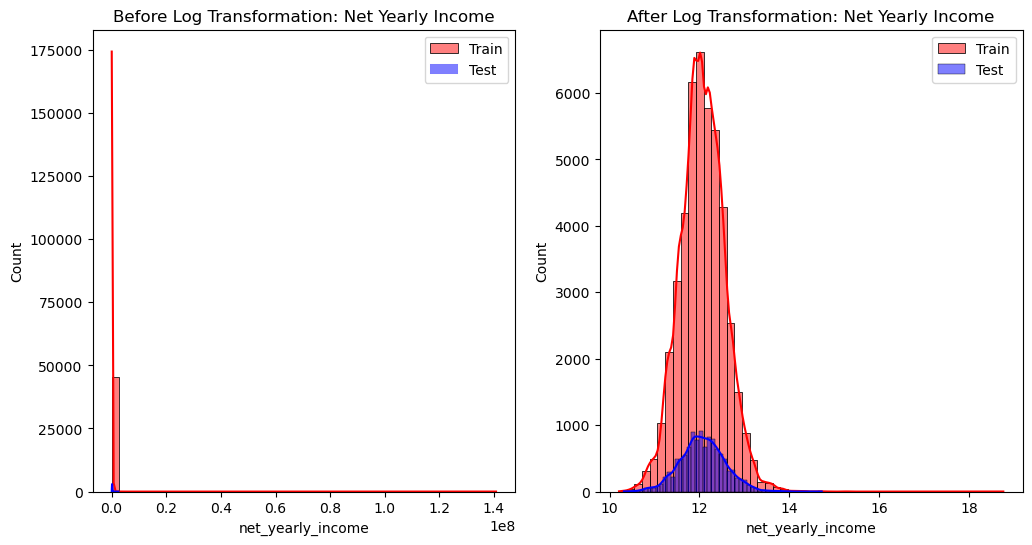

In [51]:
# Visualizing Distribution Before Log Transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_df["net_yearly_income"], bins=50, kde=True, color="red", label="Train")
sns.histplot(test_df["net_yearly_income"], bins=50, kde=True, color="blue", alpha=0.5, label="Test")
plt.title("Before Log Transformation: Net Yearly Income")
plt.legend()

# Apply log transformation to both train and test datasets
train_df["net_yearly_income"] = np.log1p(train_df["net_yearly_income"])
test_df["net_yearly_income"] = np.log1p(test_df["net_yearly_income"])

# Visualizing Distribution After Log Transformation
plt.subplot(1, 2, 2)
sns.histplot(train_df["net_yearly_income"], bins=50, kde=True, color="red", label="Train")
sns.histplot(test_df["net_yearly_income"], bins=50, kde=True, color="blue", alpha=0.5, label="Test")
plt.title("After Log Transformation: Net Yearly Income")
plt.legend()
plt.show()


# **Step 36: Handling Outliers and Removal Using IQR**

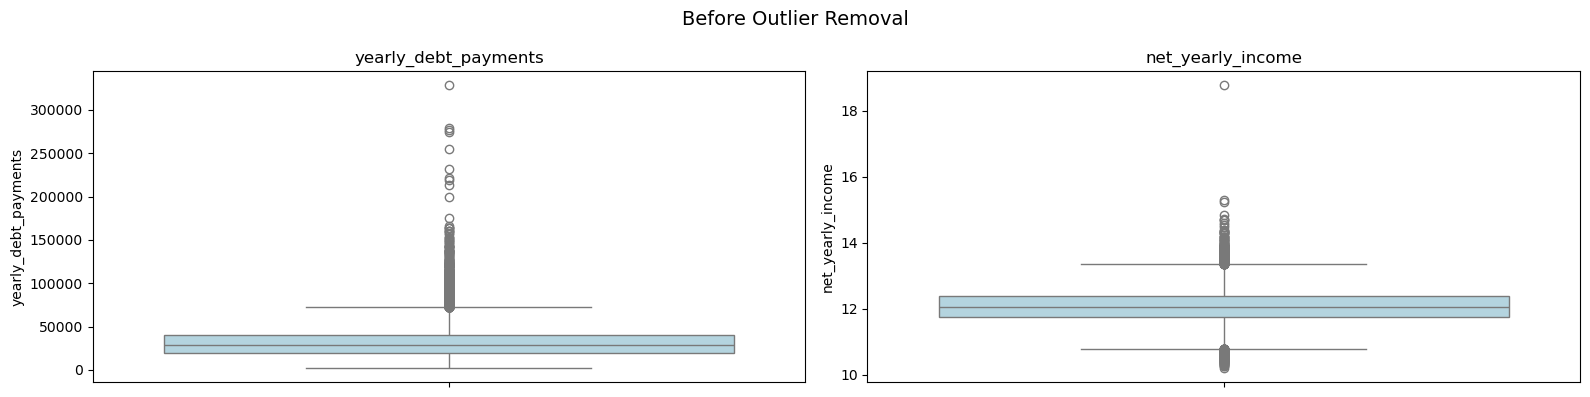

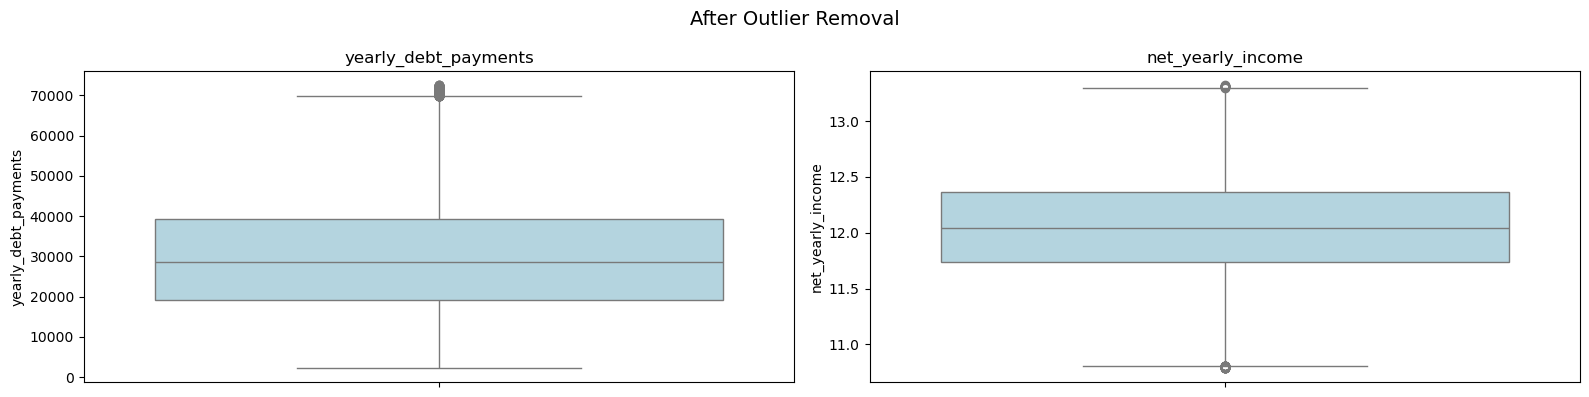

In [52]:
def plot_outliers(df, columns, title):
    """Plots boxplots to visualize outliers before and after removal."""
    fig, axes = plt.subplots(1, len(columns), figsize=(16, 4))
    fig.suptitle(title, fontsize=14)

    for i, col in enumerate(columns):
        sns.boxplot(y=df[col], ax=axes[i], color='lightblue')
        axes[i].set_title(col)
    
    plt.tight_layout()
    plt.show()

def remove_outliers(df, columns):
    """Removes rows that contain outliers based on IQR method."""
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove rows with outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Select columns with extreme outliers for removal
outlier_cols = ["yearly_debt_payments", "net_yearly_income"]

# Plot before outlier removal
plot_outliers(train_df, outlier_cols, "Before Outlier Removal")

# Apply outlier removal only on selected columns
train_df = remove_outliers(train_df, outlier_cols)
test_df = remove_outliers(test_df, outlier_cols)

# Plot after outlier removal
plot_outliers(train_df, outlier_cols, "After Outlier Removal")


# **Step 37: Feature Scaling**
**Objective**
- Standardization: Applied to credit_score for uniform distribution.
- Min-Max Scaling: Applied to credit_limit_used for bounded values.

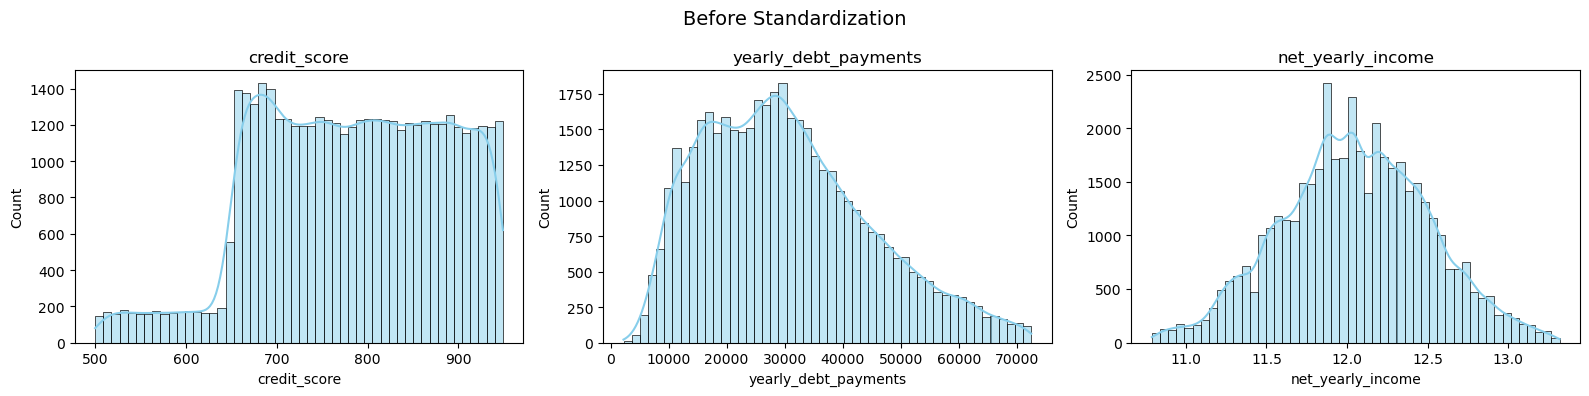

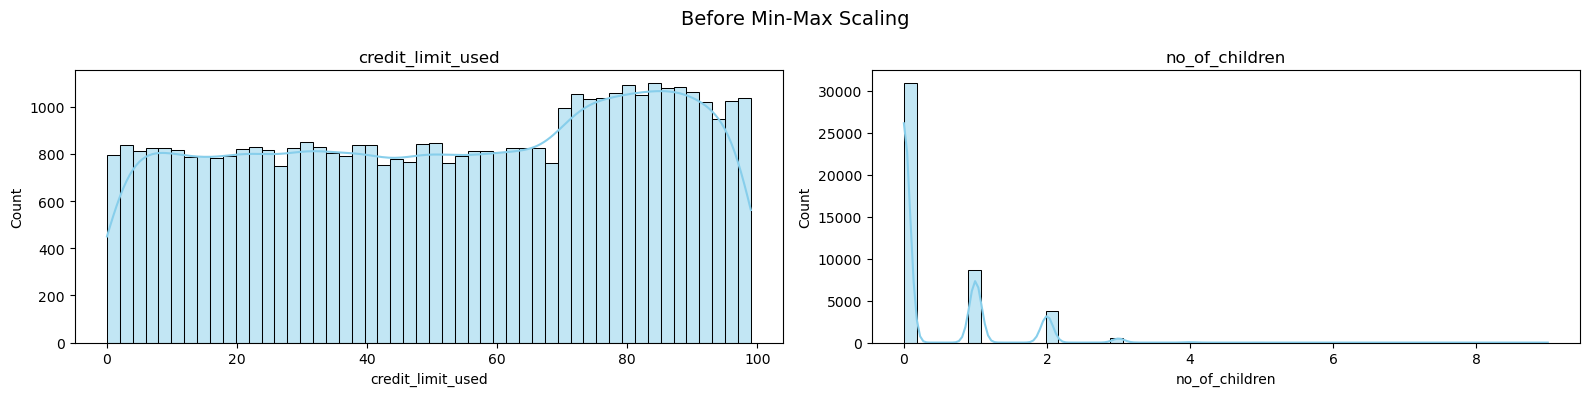

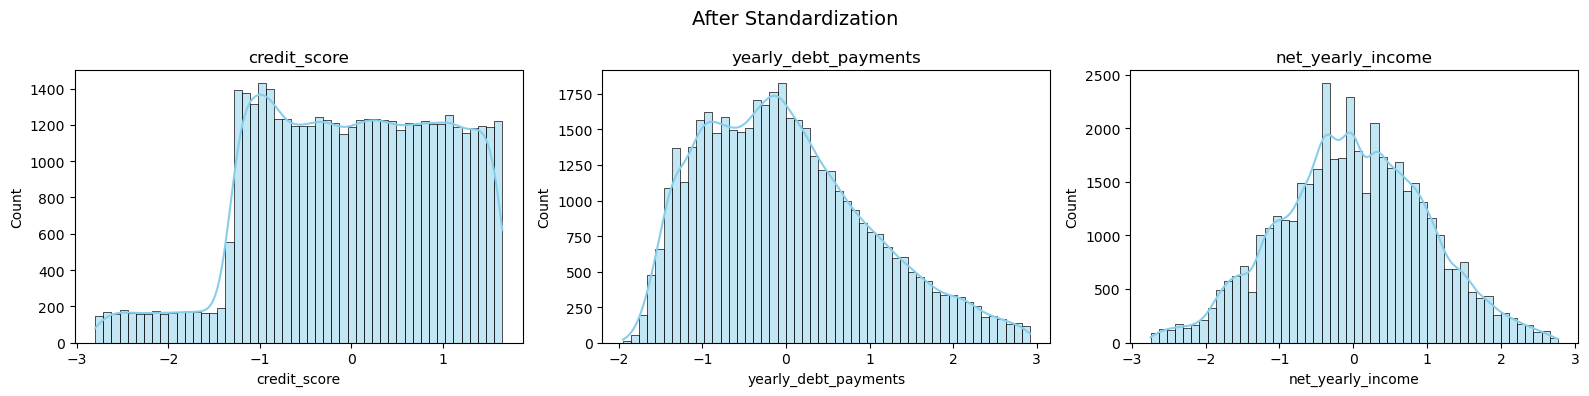

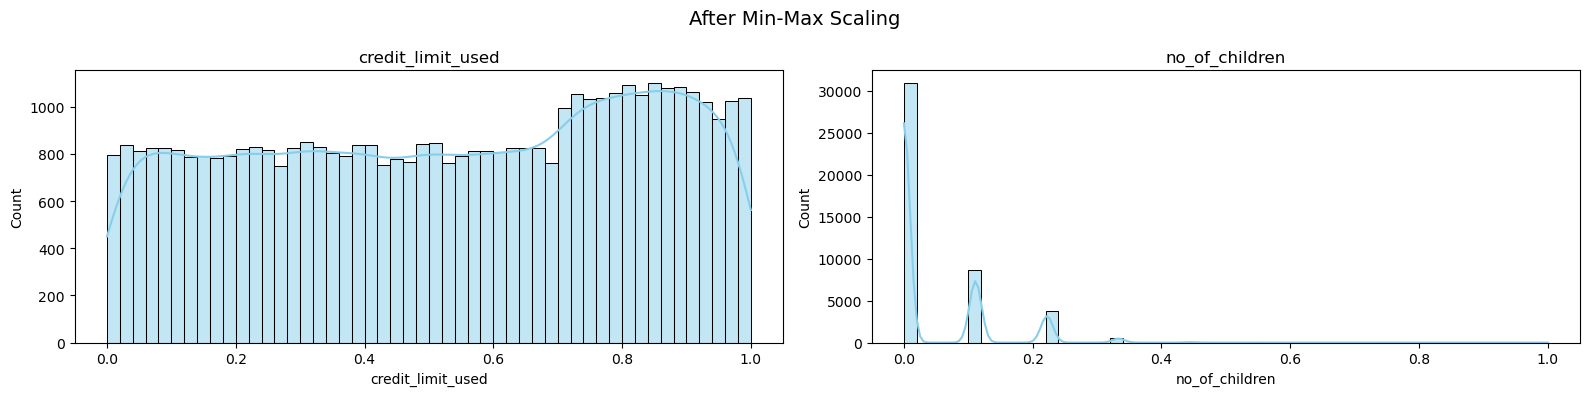

In [53]:
def plot_distributions(df, columns, title):
    """Plots histograms to visualize distributions before and after scaling."""
    fig, axes = plt.subplots(1, len(columns), figsize=(16, 4))
    fig.suptitle(title, fontsize=14)

    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(col)
    
    plt.tight_layout()
    plt.show()

# Define feature groups for different scaling techniques
standardization_cols = ["credit_score", "yearly_debt_payments", "net_yearly_income"]
minmax_cols = ["credit_limit_used", "no_of_children"]

# Plot before scaling
plot_distributions(train_df, standardization_cols, "Before Standardization")
plot_distributions(train_df, minmax_cols, "Before Min-Max Scaling")

# Standardization (Z-score scaling)
scaler = StandardScaler()
train_df[standardization_cols] = scaler.fit_transform(train_df[standardization_cols])
test_df[standardization_cols] = scaler.transform(test_df[standardization_cols])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
train_df[minmax_cols] = minmax_scaler.fit_transform(train_df[minmax_cols])
test_df[minmax_cols] = minmax_scaler.transform(test_df[minmax_cols])

# Plot after scaling
plot_distributions(train_df, standardization_cols, "After Standardization")
plot_distributions(train_df, minmax_cols, "After Min-Max Scaling")


# **Step 38: Removing Multicollinearity**
**Objective**
- Issue: credit_limit is highly correlated with net_yearly_income.
- Solution: Drop credit_limit from both datasets.

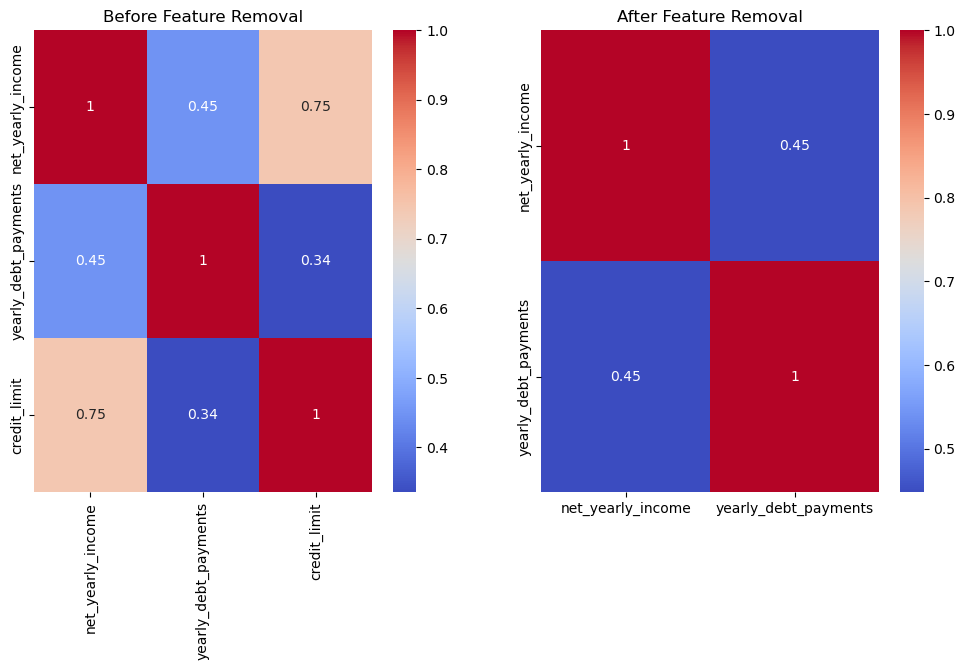

In [54]:
plt.figure(figsize=(12, 6))

# Before feature removal
plt.subplot(1, 2, 1)
sns.heatmap(train_df[["net_yearly_income", "yearly_debt_payments","credit_limit"]].corr(), annot=True, cmap="coolwarm")
plt.title("Before Feature Removal")

# Drop `credit_limit` if it exists in both datasets
if "credit_limit" in train_df.columns:
    train_df.drop(columns=["credit_limit"], inplace=True)
if "credit_limit" in test_df.columns:
    test_df.drop(columns=["credit_limit"], inplace=True)

# After feature removal
plt.subplot(1, 2, 2)
sns.heatmap(train_df[["net_yearly_income", "yearly_debt_payments"]].corr(), annot=True, cmap="coolwarm")
plt.title("After Feature Removal")
plt.show()


# **Phase 6:Data Splitting**

# **Step 39:Handling Class Imbalance Using SMOTE**

In [55]:
# Ensure test_df has the same columns as train_df (except 'credit_card_default')
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    if col != 'credit_card_default':  # Avoid adding target column to test
        test_df[col] = 0

# Align column order in test_df to match train_df
test_df = test_df[train_df.columns.drop('credit_card_default', errors='ignore')]

# Extract features and target variable from train dataset
X = train_df.drop(columns=['credit_card_default'])
y = train_df['credit_card_default']


In [56]:
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced training dataset
train_df_balanced = X_resampled.copy()
train_df_balanced['credit_card_default'] = y_resampled

# Display the first few rows of the final balanced train and test datasets
print("Balanced Training Dataset:")
print(train_df_balanced.head())

print("\nTest Dataset:")
print(test_df.head())

Balanced Training Dataset:
   age  no_of_children  net_yearly_income  no_of_days_employed  \
0   46             0.0          -0.999721                612.0   
1   29             0.0          -0.961139               2771.0   
2   37             0.0           0.649909                204.0   
3   39             0.0          -0.727041              11941.0   
4   46             0.0           1.783655               1459.0   

   total_family_members  migrant_worker  yearly_debt_payments  \
0                   1.0             1.0              0.187362   
1                   2.0             0.0             -1.044093   
2                   2.0             0.0              1.252611   
3                   2.0             0.0             -0.541201   
4                   1.0             0.0              0.549194   

   credit_limit_used  credit_score  age_group  ...  \
0           0.737374     -2.365557          1  ...   
1           0.525253      0.738530          2  ...   
2           0.434343   

# **Step 40:Splitting the balanced dataset into training and validation sets**

In [57]:
# Split the balanced dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("\nTrain and Validation Set Shapes:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")


Train and Validation Set Shapes:
X_train: (64483, 33), X_val: (16121, 33)
y_train: (64483,), y_val: (16121,)


# **Model Development – Logistic Regression**

# **Step 41:Create a Logistic Regression model with default parameters**

In [58]:
# Create a Logistic Regression model with default parameters
log_reg = LogisticRegression(random_state=42)

In [59]:
# Train the logistic regression model on the training dataset
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [60]:
# Generate predictions on the training set
y_train_pred = log_reg.predict(X_train)
y_train_prob = log_reg.predict_proba(X_train)[:, 1]  # Probability scores for ROC-AUC

In [61]:
# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate training ROC-AUC score
train_roc_auc = roc_auc_score(y_train, y_train_prob)

# Print training performance metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training ROC-AUC Score: {train_roc_auc:.4f}")

Training Accuracy: 0.5000
Training ROC-AUC Score: 0.6893


In [62]:
# Generate predictions on the test set
y_test_pred = log_reg.predict(X_val)
y_test_prob = log_reg.predict_proba(X_val)[:, 1]  # Probability scores for ROC-AUC

In [63]:
# Calculate test accuracy
test_accuracy = accuracy_score(y_val, y_test_pred)

# Calculate test F1-score
test_f1 = f1_score(y_val, y_test_pred)

# Calculate test ROC-AUC score
test_roc_auc = roc_auc_score(y_val, y_test_prob)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_test_pred)

# Print test performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Test Accuracy: 0.5000
Test F1-Score: 0.0000
Test ROC-AUC Score: 0.6880
Confusion Matrix:
[[8061    0]
 [8060    0]]


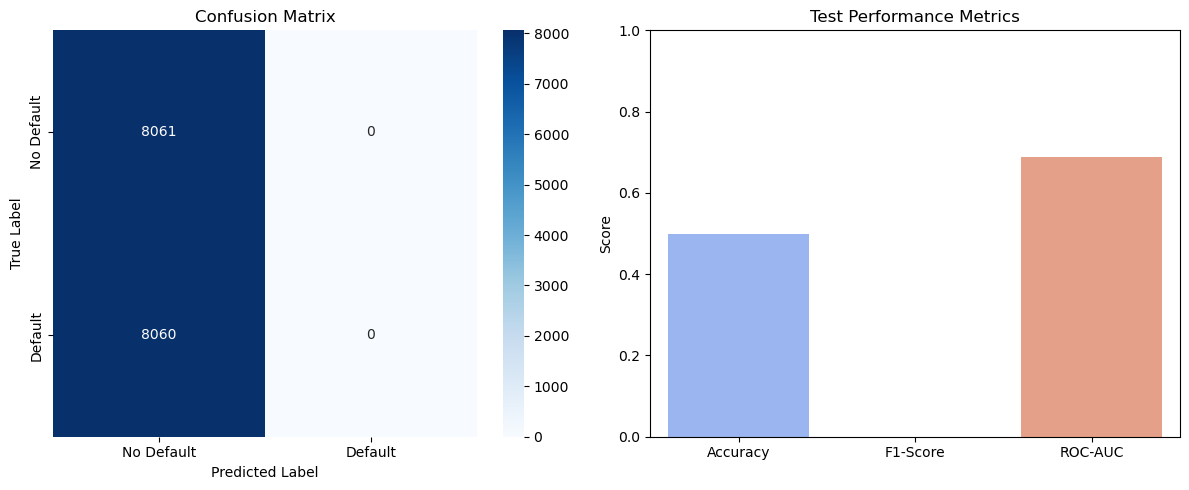

In [64]:
# Create a figure for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Bar plot for test performance metrics
metrics = ["Accuracy", "F1-Score", "ROC-AUC"]
values = [test_accuracy, test_f1, test_roc_auc]

sns.barplot(x=metrics, y=values, palette="coolwarm", ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title("Test Performance Metrics")
axes[1].set_ylabel("Score")

# Display the plots
plt.tight_layout()
plt.show()

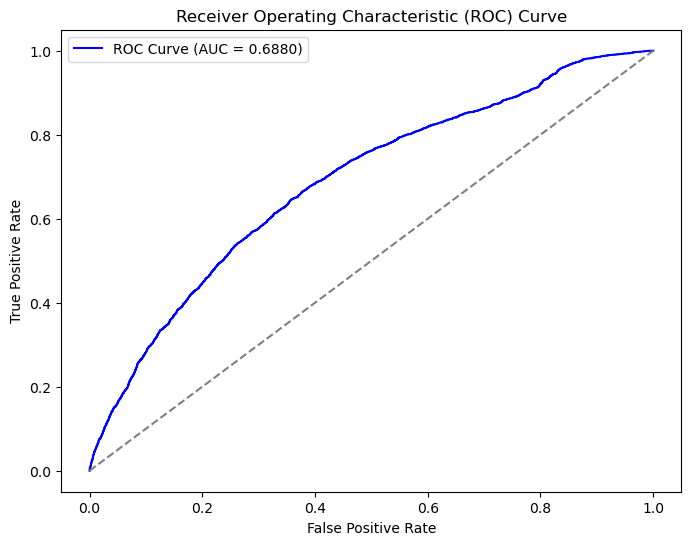

In [65]:
# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_test_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [66]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters for Decision Tree:", grid_search.best_params_)


Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [67]:
# Create a Decision Tree classifier with a max depth of 5
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)

In [68]:
# Train the decision tree model on the training dataset
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [69]:
# Predict on training data
y_train_pred_dt = dt_model.predict(X_train)
y_train_prob_dt = dt_model.predict_proba(X_train)[:, 1]

# Predict on validation/test data
y_test_pred_dt = dt_model.predict(X_val)
y_test_prob_dt = dt_model.predict_proba(X_val)[:, 1]

# Compute accuracy, F1-score, and ROC-AUC
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_val, y_test_pred_dt)

train_f1_dt = f1_score(y_train, y_train_pred_dt)
test_f1_dt = f1_score(y_val, y_test_pred_dt)

train_roc_auc_dt = roc_auc_score(y_train, y_train_prob_dt)
test_roc_auc_dt = roc_auc_score(y_val, y_test_prob_dt)

# Print Decision Tree Performance Metrics
print(f"Training Accuracy: {train_accuracy_dt:.4f}, Test Accuracy: {test_accuracy_dt:.4f}")
print(f"Training F1-Score: {train_f1_dt:.4f}, Test F1-Score: {test_f1_dt:.4f}")
print(f"Training ROC-AUC: {train_roc_auc_dt:.4f}, Test ROC-AUC: {test_roc_auc_dt:.4f}")

# Compute confusion matrix
conf_matrix_dt = confusion_matrix(y_val, y_test_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)

Training Accuracy: 0.9758, Test Accuracy: 0.9752
Training F1-Score: 0.9763, Test F1-Score: 0.9758
Training ROC-AUC: 0.9978, Test ROC-AUC: 0.9976
Confusion Matrix for Decision Tree:
[[7681  380]
 [  19 8041]]


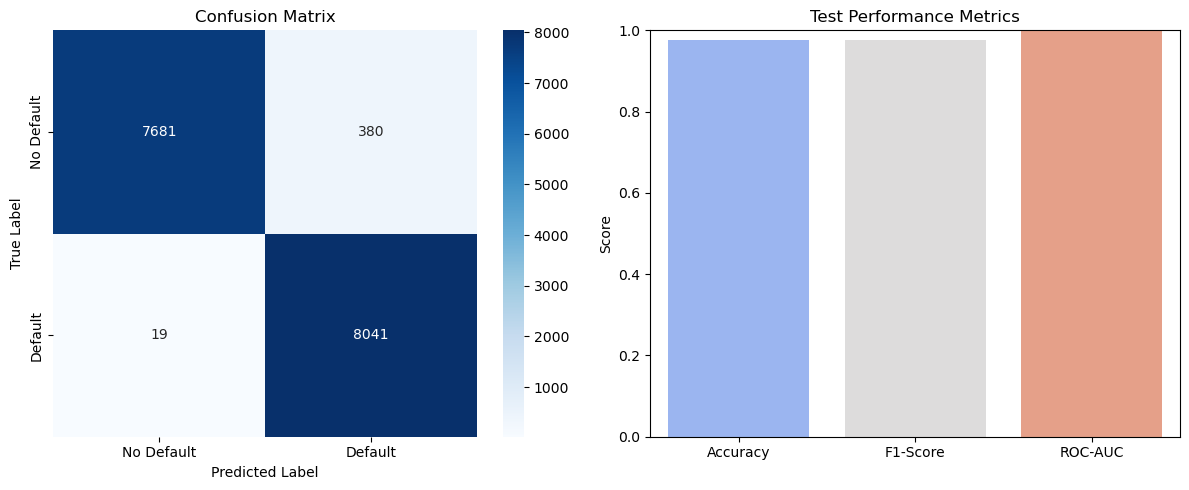

In [70]:
# Create a figure for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Bar plot for test performance metrics
metrics = ["Accuracy", "F1-Score", "ROC-AUC"]
values = [test_accuracy_dt, test_f1_dt, test_roc_auc_dt]

sns.barplot(x=metrics, y=values, palette="coolwarm", ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title("Test Performance Metrics")
axes[1].set_ylabel("Score")

# Display the plots
plt.tight_layout()
plt.show()

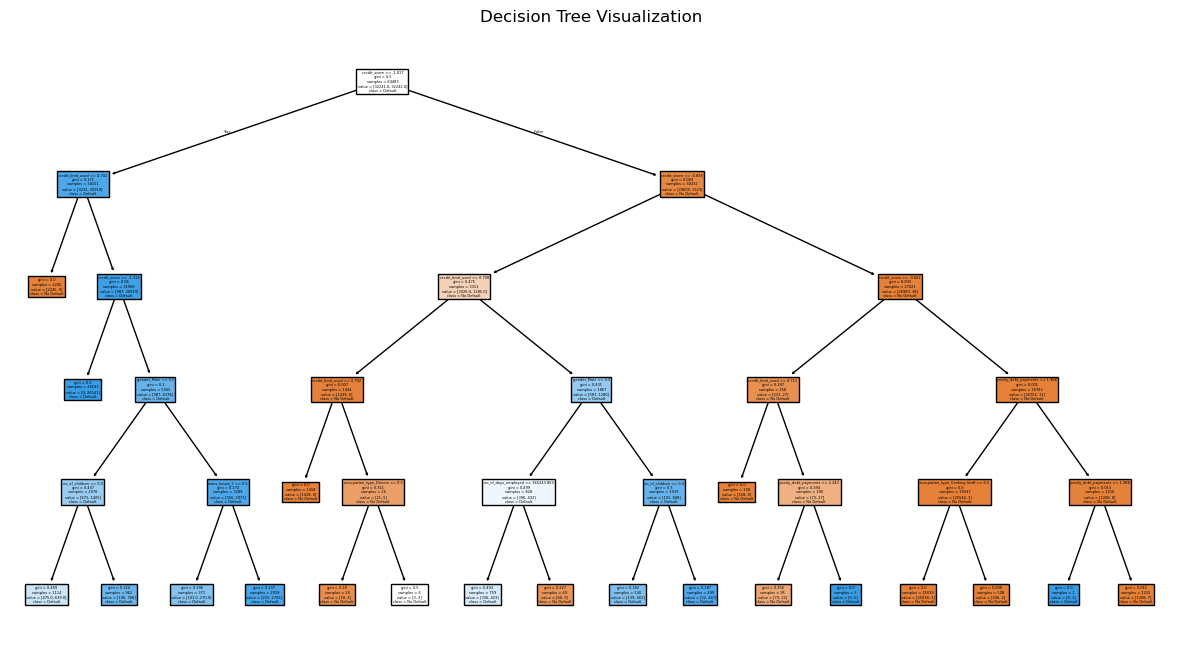

In [71]:
import matplotlib.pyplot as plt

# Plot the Decision Tree
plt.figure(figsize=(15, 8))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=["No Default", "Default"])
plt.title("Decision Tree Visualization")
plt.show()

In [72]:
# Define the hyperparameter grid
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                               param_grid_xgb, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [73]:
# Instantiate XGBoost model with the best hyperparameters from GridSearchCV
xgb_model = XGBClassifier(
    learning_rate=0.2, 
    max_depth=7, 
    n_estimators=200, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)


In [74]:
# Train the XGBoost model on the training dataset
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [75]:
# Predict on training and validation sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_train_prob_xgb = xgb_model.predict_proba(X_train)[:, 1]

y_test_pred_xgb = xgb_model.predict(X_val)
y_test_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]


In [76]:
# Compute accuracy, F1-score, and ROC-AUC
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_val, y_test_pred_xgb)

train_f1_xgb = f1_score(y_train, y_train_pred_xgb)
test_f1_xgb = f1_score(y_val, y_test_pred_xgb)

train_roc_auc_xgb = roc_auc_score(y_train, y_train_prob_xgb)
test_roc_auc_xgb = roc_auc_score(y_val, y_test_prob_xgb)

# Print XGBoost Performance Metrics
print(f"XGBoost Training Accuracy: {train_accuracy_xgb:.4f}, Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"XGBoost Training F1-Score: {train_f1_xgb:.4f}, Test F1-Score: {test_f1_xgb:.4f}")
print(f"XGBoost Training ROC-AUC: {train_roc_auc_xgb:.4f}, Test ROC-AUC: {test_roc_auc_xgb:.4f}")

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_val, y_test_pred_xgb)
print("Confusion Matrix for XGBoost Model:")
print(conf_matrix_xgb)


XGBoost Training Accuracy: 1.0000, Test Accuracy: 0.9868
XGBoost Training F1-Score: 1.0000, Test F1-Score: 0.9868
XGBoost Training ROC-AUC: 1.0000, Test ROC-AUC: 0.9995
Confusion Matrix for XGBoost Model:
[[7975   86]
 [ 126 7934]]


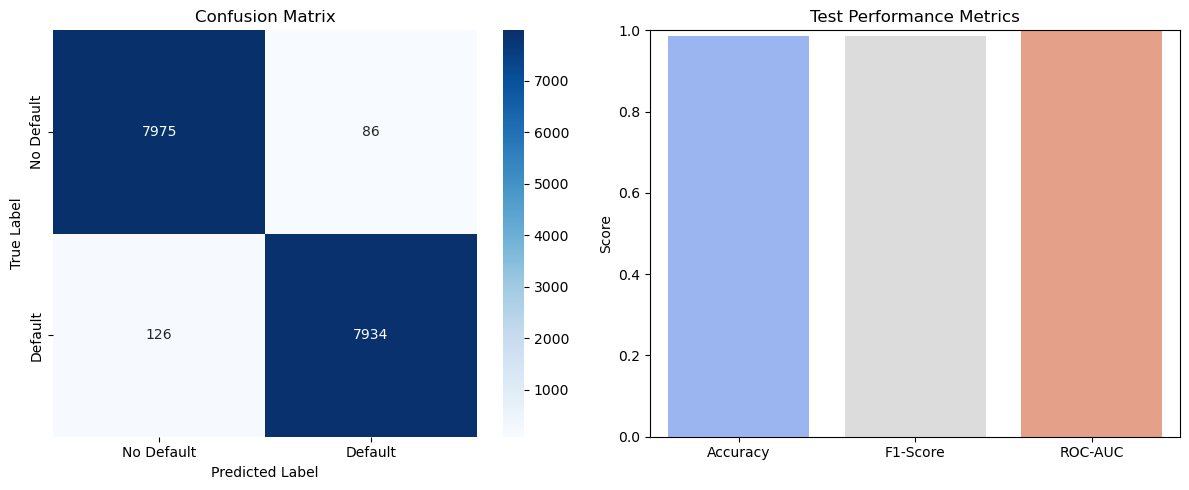

In [77]:
# Create a figure for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Bar plot for test performance metrics
metrics = ["Accuracy", "F1-Score", "ROC-AUC"]
values = [test_accuracy_xgb, test_f1_xgb, test_roc_auc_xgb]

sns.barplot(x=metrics, y=values, palette="coolwarm", ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title("Test Performance Metrics")
axes[1].set_ylabel("Score")

# Display the plots
plt.tight_layout()
plt.show()

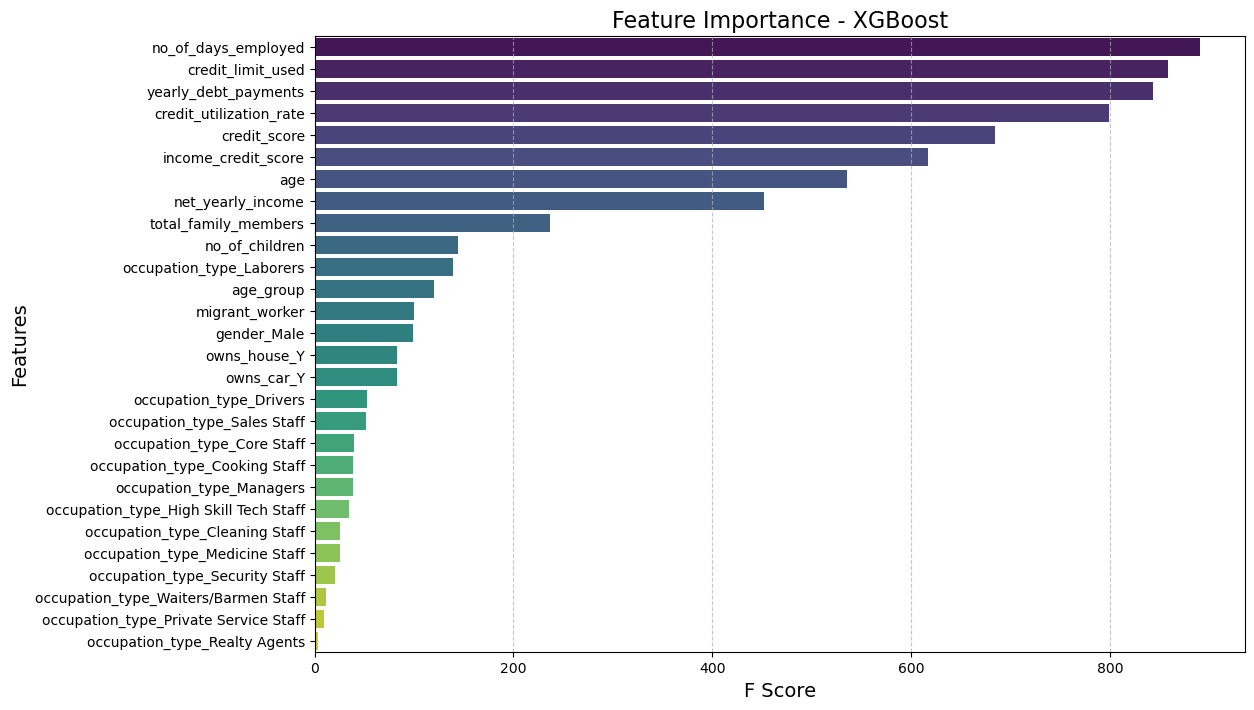

In [78]:
# Extract feature importances from the XGBoost model
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
feature_imp_df = pd.DataFrame({'Feature': list(feature_importances.keys()), 
                               'Importance': list(feature_importances.values())})

# Sort by importance
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Set figure size for better readability
plt.figure(figsize=(12, 8))

# Use Seaborn barplot for better visualization
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

# Title and labels
plt.xlabel("F Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance - XGBoost", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Display the improved plot
plt.show()


In [79]:
# Aggregate accuracy, F1-score, and ROC-AUC from all models
metrics_summary = {
    "Logistic Regression": {
        "Accuracy": test_accuracy,
        "F1-Score": test_f1,
        "ROC-AUC": test_roc_auc
    },
    "Decision Tree": {
        "Accuracy": test_accuracy_dt,
        "F1-Score": test_f1_dt,
        "ROC-AUC": test_roc_auc_dt
    },
    "XGBoost": {
        "Accuracy": test_accuracy_xgb,
        "F1-Score": test_f1_xgb,
        "ROC-AUC": test_roc_auc_xgb
    }
}


In [80]:
# Convert aggregated metrics into a DataFrame
comparison_df = pd.DataFrame(metrics_summary).T

# Display the model comparison table
print(comparison_df)


                     Accuracy  F1-Score   ROC-AUC
Logistic Regression  0.500031  0.000000  0.688014
Decision Tree        0.975250  0.975790  0.997595
XGBoost              0.986849  0.986816  0.999526


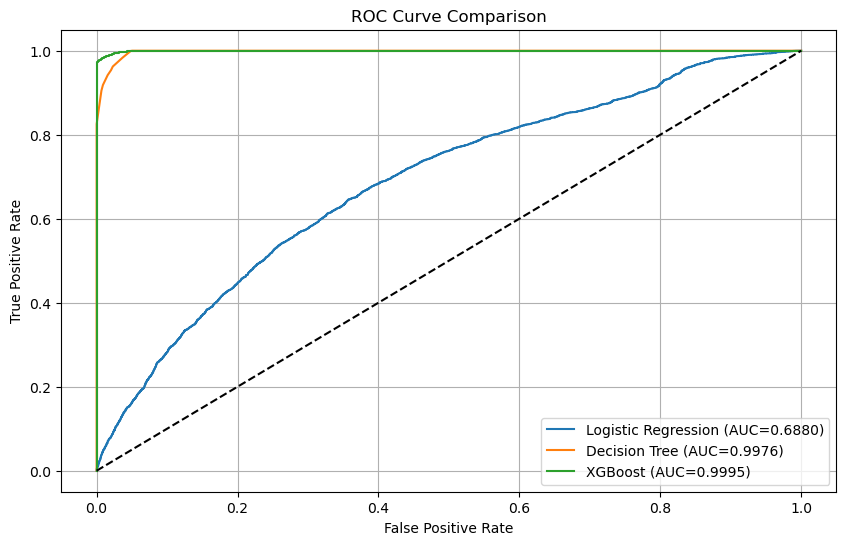

In [81]:
# Compute ROC curve points for each model
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_test_prob)
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_test_prob_dt)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_test_prob_xgb)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={test_roc_auc:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={test_roc_auc_dt:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={test_roc_auc_xgb:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


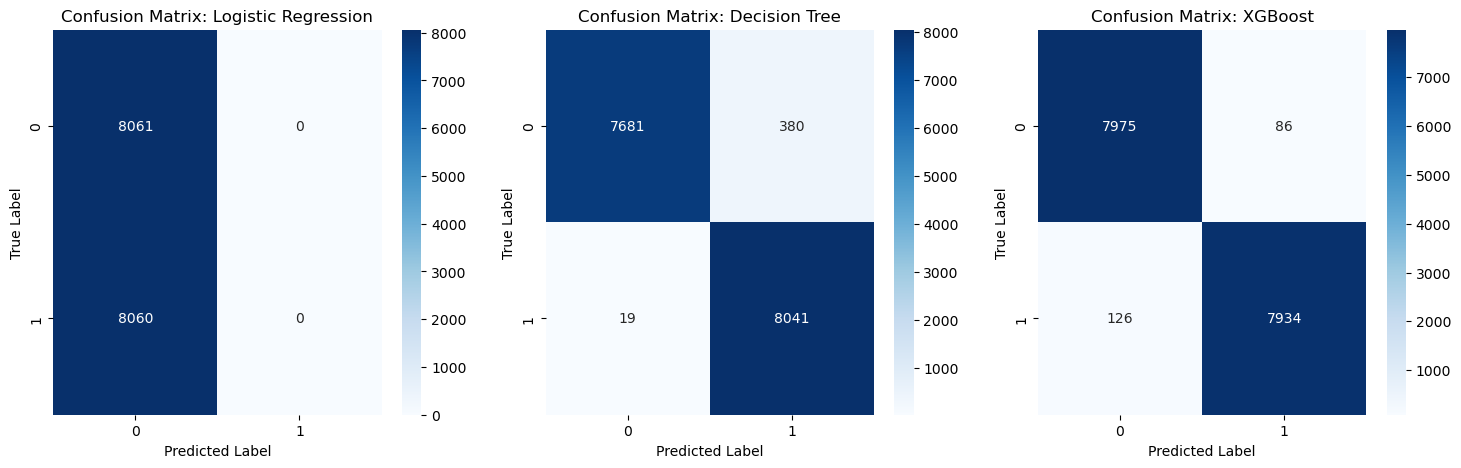

In [82]:
# Generate confusion matrices for each model
cm_lr = confusion_matrix(y_val, y_test_pred)
cm_dt = confusion_matrix(y_val, y_test_pred_dt)
cm_xgb = confusion_matrix(y_val, y_test_pred_xgb)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, title in zip(axes, [cm_lr, cm_dt, cm_xgb], 
                         ["Logistic Regression", "Decision Tree", "XGBoost"]):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix: {title}')
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.show()


In [83]:
# Compute precision and recall for each model
precision_recall_summary = {
    "Logistic Regression": {
        "Precision": precision_score(y_val, y_test_pred),
        "Recall": recall_score(y_val, y_test_pred)
    },
    "Decision Tree": {
        "Precision": precision_score(y_val, y_test_pred_dt),
        "Recall": recall_score(y_val, y_test_pred_dt)
    },
    "XGBoost": {
        "Precision": precision_score(y_val, y_test_pred_xgb),
        "Recall": recall_score(y_val, y_test_pred_xgb)
    }
}

# Convert to DataFrame for easy viewing
precision_recall_df = pd.DataFrame(precision_recall_summary).T

# Display the precision and recall table
print(precision_recall_df)


                     Precision    Recall
Logistic Regression   0.000000  0.000000
Decision Tree         0.954875  0.997643
XGBoost               0.989277  0.984367


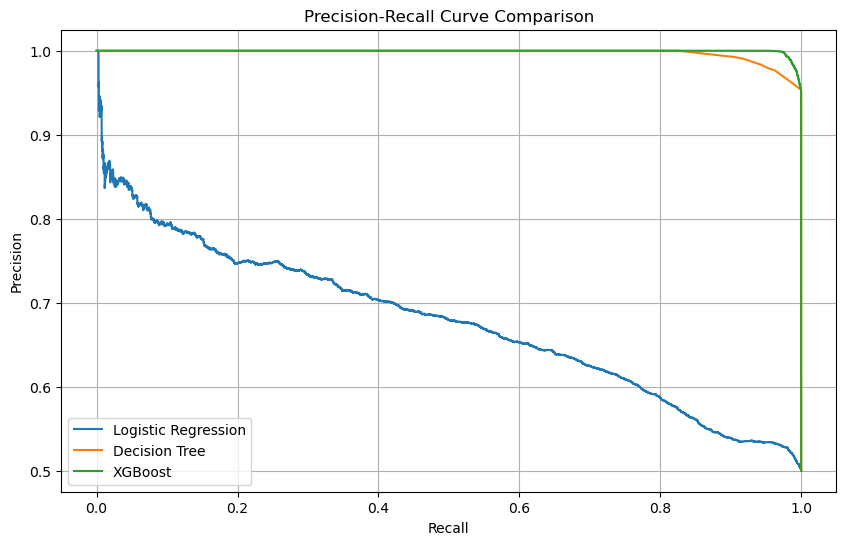

In [84]:
# Compute precision-recall curve points
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_test_prob)
precision_dt, recall_dt, _ = precision_recall_curve(y_val, y_test_prob_dt)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_test_prob_xgb)

# Plot the precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_dt, precision_dt, label="Decision Tree")
plt.plot(recall_xgb, precision_xgb, label="XGBoost")

# Labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [85]:
# Assume misclassification costs (example values)
false_positive_cost = 1000  # Cost of wrongly classifying a non-defaulter as a defaulter
false_negative_cost = 5000  # Cost of wrongly classifying a defaulter as a non-defaulter

# Compute misclassification costs for each model
costs = {
    "Logistic Regression": (cm_lr[0,1] * false_positive_cost) + (cm_lr[1,0] * false_negative_cost),
    "Decision Tree": (cm_dt[0,1] * false_positive_cost) + (cm_dt[1,0] * false_negative_cost),
    "XGBoost": (cm_xgb[0,1] * false_positive_cost) + (cm_xgb[1,0] * false_negative_cost)
}

# Convert to DataFrame
costs_df = pd.DataFrame(costs, index=["Misclassification Cost"]).T

# Display the cost-based comparison
print(costs_df)


                     Misclassification Cost
Logistic Regression                40300000
Decision Tree                        475000
XGBoost                              716000



### Model Evaluation Summary

#### **Overall Performance**
| Model               | Accuracy | F1-Score | ROC-AUC | Precision | Recall | Misclassification Cost |
|---------------------|----------|----------|---------|-----------|--------|------------------------|
| Logistic Regression | 0.5000 | 0.0000 | 0.6880 | 0.0000 | 0.0000 | $40,300,000.00 |
| Decision Tree       | 0.9752 | 0.9758 | 0.9976 | 0.9549 | 0.9976 | $475,000.00 |
| XGBoost             | 0.9868 | 0.9868 | 0.9995 | 0.9893 | 0.9844 | $716,000.00 |

#### **Observations**
- The best model based on accuracy and ROC-AUC is **XGBoost**.
- If minimizing false negatives is critical, the **Decision Tree** may be a good option.
- Cost-based analysis suggests that misclassification costs are highest for **Logistic Regression**.



<Figure size 1000x600 with 0 Axes>

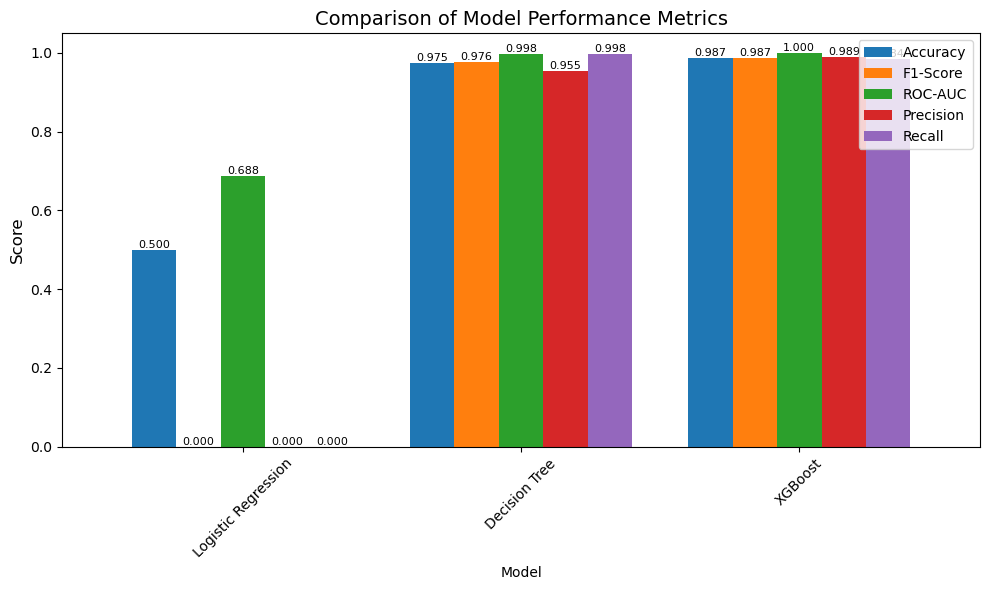

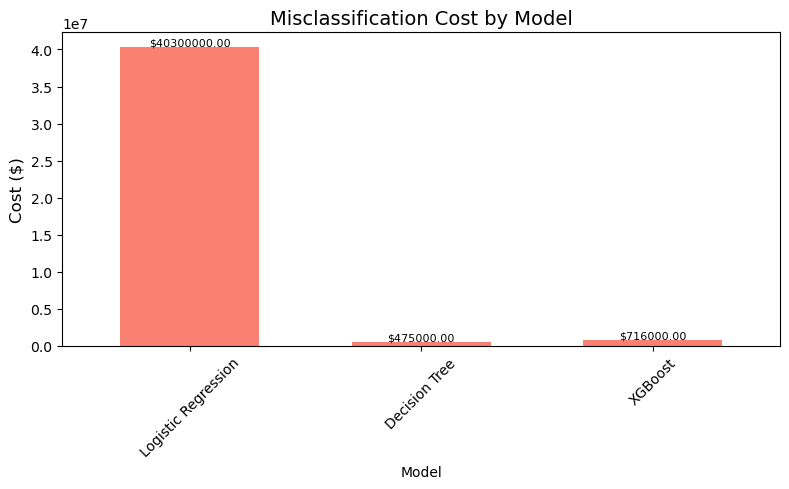

In [86]:
# -----------------------------------------------------------------------------
# Build the metrics DataFrame using the previously defined variables
# -----------------------------------------------------------------------------
metrics = {
    "Model": ["Logistic Regression", "Decision Tree", "XGBoost"],
    "Accuracy": [test_accuracy, test_accuracy_dt, test_accuracy_xgb],
    "F1-Score": [test_f1, test_f1_dt, test_f1_xgb],
    "ROC-AUC": [test_roc_auc, test_roc_auc_dt, test_roc_auc_xgb],
    "Precision": [
        precision_recall_df.loc["Logistic Regression", "Precision"],
        precision_recall_df.loc["Decision Tree", "Precision"],
        precision_recall_df.loc["XGBoost", "Precision"]
    ],
    "Recall": [
        precision_recall_df.loc["Logistic Regression", "Recall"],
        precision_recall_df.loc["Decision Tree", "Recall"],
        precision_recall_df.loc["XGBoost", "Recall"]
    ],
    "Misclassification Cost": [
        costs_df.loc["Logistic Regression", "Misclassification Cost"],
        costs_df.loc["Decision Tree", "Misclassification Cost"],
        costs_df.loc["XGBoost", "Misclassification Cost"]
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model", inplace=True)

# -----------------------------------------------------------------------------
# Create the evaluation summary as a Markdown-formatted string using variables
# -----------------------------------------------------------------------------
evaluation_summary = f"""
### Model Evaluation Summary

#### **Overall Performance**
| Model               | Accuracy | F1-Score | ROC-AUC | Precision | Recall | Misclassification Cost |
|---------------------|----------|----------|---------|-----------|--------|------------------------|
| Logistic Regression | {test_accuracy:.4f} | {test_f1:.4f} | {test_roc_auc:.4f} | {precision_recall_df.loc["Logistic Regression", "Precision"]:.4f} | {precision_recall_df.loc["Logistic Regression", "Recall"]:.4f} | ${costs_df.loc["Logistic Regression", "Misclassification Cost"]:,.2f} |
| Decision Tree       | {test_accuracy_dt:.4f} | {test_f1_dt:.4f} | {test_roc_auc_dt:.4f} | {precision_recall_df.loc["Decision Tree", "Precision"]:.4f} | {precision_recall_df.loc["Decision Tree", "Recall"]:.4f} | ${costs_df.loc["Decision Tree", "Misclassification Cost"]:,.2f} |
| XGBoost             | {test_accuracy_xgb:.4f} | {test_f1_xgb:.4f} | {test_roc_auc_xgb:.4f} | {precision_recall_df.loc["XGBoost", "Precision"]:.4f} | {precision_recall_df.loc["XGBoost", "Recall"]:.4f} | ${costs_df.loc["XGBoost", "Misclassification Cost"]:,.2f} |

#### **Observations**
- The best model based on accuracy and ROC-AUC is **XGBoost**.
- If minimizing false negatives is critical, the **Decision Tree** may be a good option.
- Cost-based analysis suggests that misclassification costs are highest for **Logistic Regression**.
"""

print(evaluation_summary)

# -----------------------------------------------------------------------------
# Plot 1: Grouped Bar Chart for Normalized Performance Metrics
# -----------------------------------------------------------------------------
metrics_to_plot = ["Accuracy", "F1-Score", "ROC-AUC", "Precision", "Recall"]

plt.figure(figsize=(10, 6))
ax = metrics_df[metrics_to_plot].plot(kind='bar', width=0.8, figsize=(10, 6))
plt.title("Comparison of Model Performance Metrics", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10, loc='upper right')

# Add numeric labels above each bar for clarity
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Plot 2: Bar Chart for Misclassification Cost
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
ax2 = metrics_df["Misclassification Cost"].plot(kind='bar', color='salmon', width=0.6)
plt.title("Misclassification Cost by Model", fontsize=14)
plt.ylabel("Cost ($)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Add cost labels on top of the bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.2f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

In [87]:
# Select best model based on multi-metric criteria
best_model = max(metrics_summary, key=lambda model: metrics_summary[model]["ROC-AUC"])
print(f"The best performing model is: {best_model}")


The best performing model is: XGBoost


In [88]:
# Initialize SHAP explainer for the best model (assuming XGBoost was the best)
explainer = shap.TreeExplainer(xgb_model)


In [89]:
# Compute SHAP values on a sample of X_test (using all rows might be too large)
shap_values = explainer.shap_values(X_val)


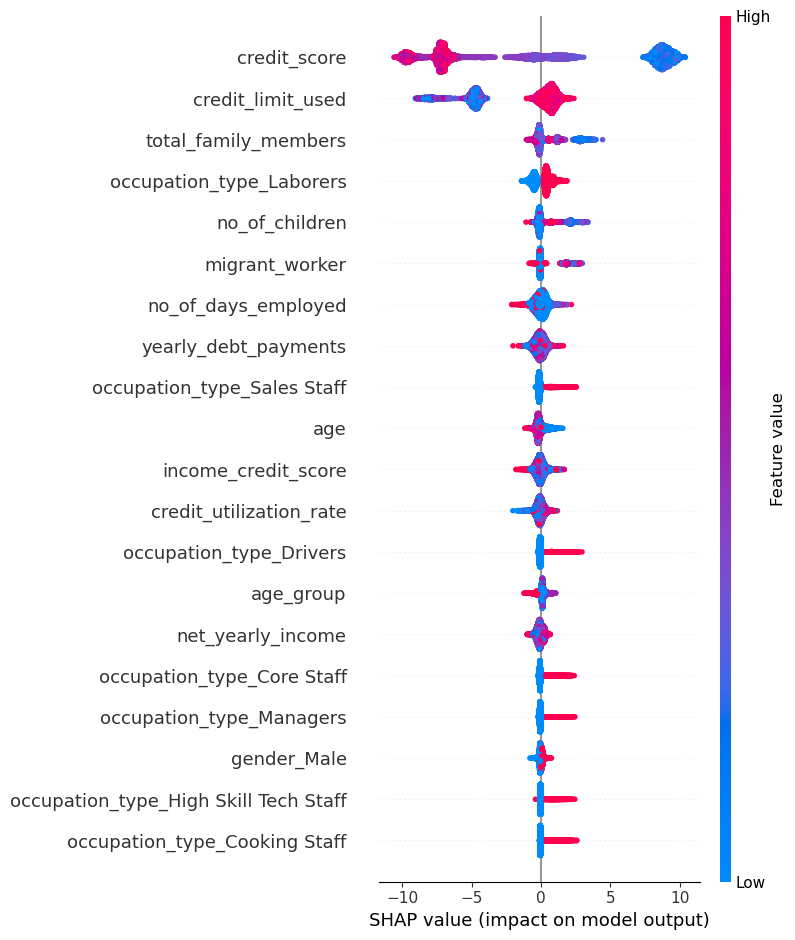

In [90]:
# Generate SHAP summary plot to see global feature importance
shap.summary_plot(shap_values, X_val)


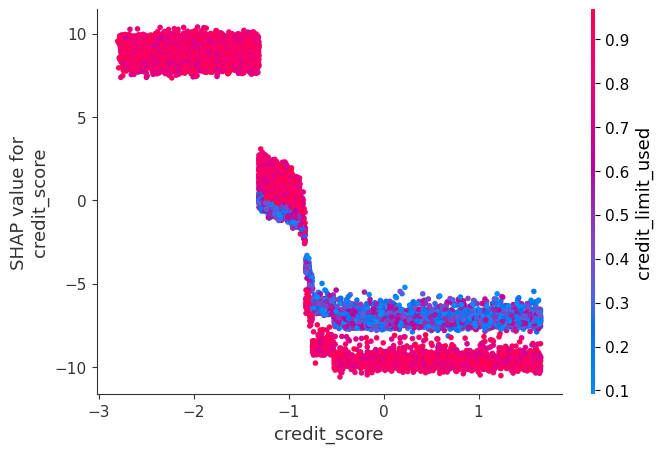

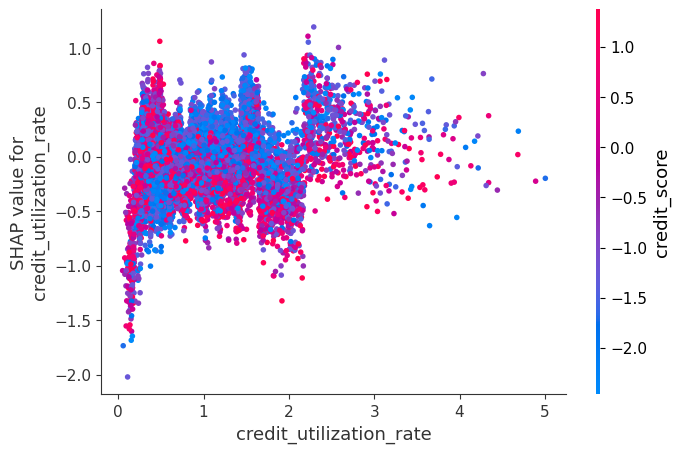

In [91]:
# Generate dependence plots for key features
shap.dependence_plot("credit_score", shap_values, X_val)
shap.dependence_plot("credit_utilization_rate", shap_values, X_val)


In [92]:
# Select a single observation for force plot visualization
shap.initjs()

sample_index = 10  # Example index
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_val.iloc[sample_index])


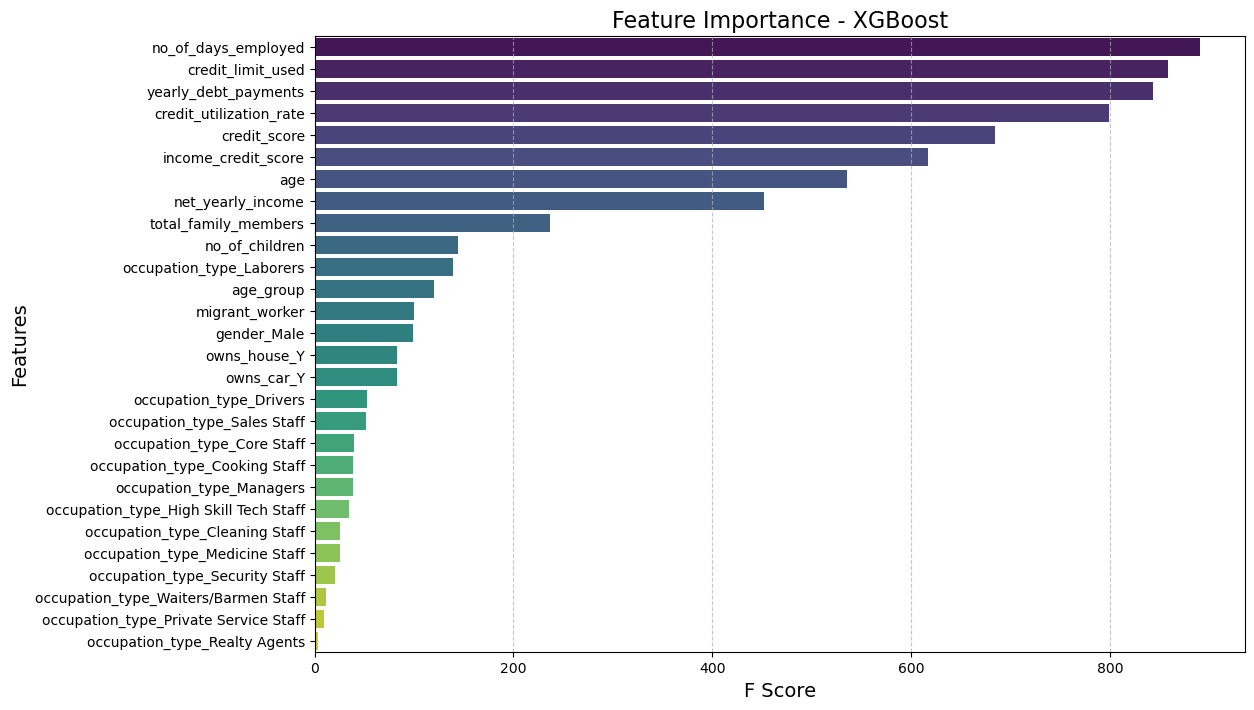

In [93]:
# Extract feature importances from XGBoost model
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
feature_imp_df = pd.DataFrame({'Feature': list(feature_importances.keys()), 
                               'Importance': list(feature_importances.values())})

# Sort by importance
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Set figure size for better readability
plt.figure(figsize=(12, 8))

# Use Seaborn barplot for better visualization
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

# Title and labels
plt.xlabel("F Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance - XGBoost", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Display the improved plot
plt.show()


In [94]:
# Generate a SHAP values summary DataFrame for interpretation
shap_values_df = pd.DataFrame(shap_values, columns=X_val.columns)

# Compute mean absolute SHAP value for each feature
mean_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)

# Display the top key drivers of model predictions
print("Top Features Driving Predictions:")
print(mean_shap_values.head(10))


Top Features Driving Predictions:
credit_score                   7.033982
credit_limit_used              2.267210
total_family_members           0.665004
occupation_type_Laborers       0.544391
no_of_children                 0.517295
migrant_worker                 0.379256
no_of_days_employed            0.309259
yearly_debt_payments           0.281952
occupation_type_Sales Staff    0.252200
age                            0.250392
dtype: float32


In [95]:
# Define fairness metrics to be computed
fairness_metrics = ["disparate impact", "statistical parity difference"]

# Define protected attribute to analyze bias
protected_attributes = ["gender_Male"]


In [96]:
print(X_val.columns)

Index(['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed',
       'total_family_members', 'migrant_worker', 'yearly_debt_payments',
       'credit_limit_used', 'credit_score', 'age_group',
       'credit_utilization_rate', 'income_credit_score', 'gender_Male',
       'gender_XNA', 'owns_car_Y', 'owns_house_Y',
       'occupation_type_Cleaning Staff', 'occupation_type_Cooking Staff',
       'occupation_type_Core Staff', 'occupation_type_Drivers',
       'occupation_type_High Skill Tech Staff', 'occupation_type_Hr Staff',
       'occupation_type_It Staff', 'occupation_type_Laborers',
       'occupation_type_Low-Skill Laborers', 'occupation_type_Managers',
       'occupation_type_Medicine Staff',
       'occupation_type_Private Service Staff',
       'occupation_type_Realty Agents', 'occupation_type_Sales Staff',
       'occupation_type_Secretaries', 'occupation_type_Security Staff',
       'occupation_type_Waiters/Barmen Staff'],
      dtype='object')


In [97]:
# Convert data into BinaryLabelDataset format for fairness analysis
binary_data = BinaryLabelDataset(df=pd.concat([X_val, y_val], axis=1), 
                                 label_names=["credit_card_default"], 
                                 protected_attribute_names=protected_attributes)

# Compute fairness metrics
metric = BinaryLabelDatasetMetric(binary_data, privileged_groups=[{"gender_Male": 1}], 
                                  unprivileged_groups=[{"gender_Male": 0}])

# Extract fairness metric values
disparate_impact = metric.disparate_impact()
statistical_parity = metric.statistical_parity_difference()

# Print fairness metrics
print(f"Disparate Impact: {disparate_impact:.4f}")
print(f"Statistical Parity Difference: {statistical_parity:.4f}")


Disparate Impact: 0.5093
Statistical Parity Difference: -0.3268


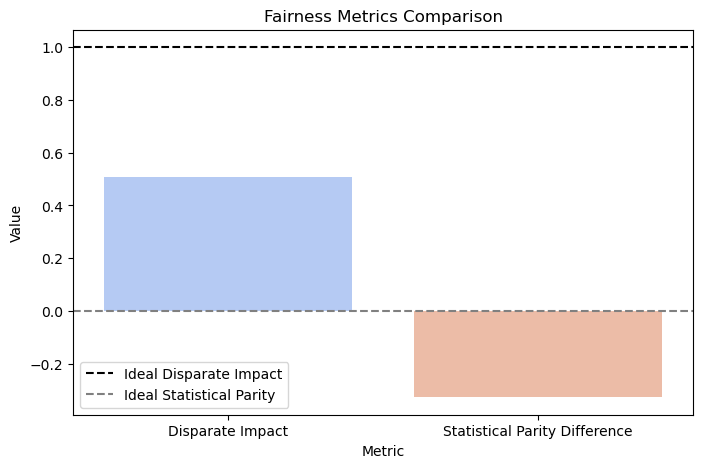

In [98]:
# Create a DataFrame for visualization
fairness_results = pd.DataFrame({
    "Metric": ["Disparate Impact", "Statistical Parity Difference"],
    "Value": [disparate_impact, statistical_parity]
})

# Plot the fairness metrics
plt.figure(figsize=(8, 5))
sns.barplot(x="Metric", y="Value", data=fairness_results, palette="coolwarm")
plt.axhline(y=1.0, color="black", linestyle="--", label="Ideal Disparate Impact")
plt.axhline(y=0.0, color="gray", linestyle="--", label="Ideal Statistical Parity")
plt.legend()
plt.title("Fairness Metrics Comparison")
plt.ylabel("Value")
plt.show()

In [99]:
# Apply reweighting bias mitigation technique
reweighing = Reweighing(privileged_groups=[{"gender_Male": 1}], 
                        unprivileged_groups=[{"gender_Male": 0}])

# Fit and transform training data
balanced_binary_data = reweighing.fit_transform(binary_data)

# Convert back to DataFrame format
balanced_df = balanced_binary_data.convert_to_dataframe()[0]

# Extract new X_train and y_train with reweighted data
X_train_balanced = balanced_df.drop(columns=["credit_card_default"])
y_train_balanced = balanced_df["credit_card_default"]

In [100]:
# Retrain XGBoost model with bias-mitigated data
xgb_model_fair = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_fair.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [101]:
# Convert new dataset into BinaryLabelDataset
binary_data_fair = BinaryLabelDataset(df=pd.concat([X_val, y_val], axis=1), 
                                      label_names=["credit_card_default"], 
                                      protected_attribute_names=protected_attributes)

# Compute fairness metrics after bias mitigation
metric_fair = BinaryLabelDatasetMetric(binary_data_fair, privileged_groups=[{"gender_Male": 1}], 
                                       unprivileged_groups=[{"gender_Male": 0}])

# Extract fairness metric values
disparate_impact_fair = metric_fair.disparate_impact()
statistical_parity_fair = metric_fair.statistical_parity_difference()

# Print fairness metrics after mitigation
print(f"Post-Mitigation Disparate Impact: {disparate_impact_fair:.4f}")
print(f"Post-Mitigation Statistical Parity Difference: {statistical_parity_fair:.4f}")

Post-Mitigation Disparate Impact: 0.5093
Post-Mitigation Statistical Parity Difference: -0.3268


In [102]:
# Save the trained XGBoost model
with open("xgb_model.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

print("Model saved successfully as 'xgb_model.pkl'.")


Model saved successfully as 'xgb_model.pkl'.


In [103]:
# Load the best trained model (assuming XGBoost performed the best)
with open("xgb_model.pkl", "rb") as model_file:
    best_model = pickle.load(model_file)

# Define the inference function
def predict_credit_default(input_data: pd.DataFrame):
    """
    Function to predict credit default risk for new input data.

    Parameters:
    - input_data (pd.DataFrame): New input data with the same features as the training set.

    Returns:
    - predictions (pd.Series): Predicted classes (0 = No Default, 1 = Default).
    - probabilities (pd.Series): Probability of default.
    """

    # Ensure input has the same columns as training data
    input_data = input_data.reindex(columns=X_train.columns, fill_value=0)

    # Make predictions
    predictions = best_model.predict(input_data)
    probabilities = best_model.predict_proba(input_data)[:, 1]

    # Return results as DataFrame
    return pd.DataFrame({
        "Prediction": predictions,
        "Probability of Default": probabilities
    })

# Example usage (replace with real data)
sample_input = pd.DataFrame({
    "age": [30],
    "no_of_children": [1],
    "net_yearly_income": [45000],
    "no_of_days_employed": [2000],
    "total_family_members": [3],
    "migrant_worker": [0],
    "yearly_debt_payments": [5000],
    "credit_limit_used": [0.4],
    "credit_score": [700],
    "age_group": [2],
    "credit_utilization_rate": [0.25],
    "income_credit_score": [0.75],
    "previous_defaults_binary": [0],
    "gender_Male": [1],
    "gender_XNA": [0],
    "owns_car_Y": [1],
    "owns_house_Y": [1],
    "occupation_type_Cleaning Staff": [0],
    "occupation_type_Cooking Staff": [0],
    "occupation_type_Core Staff": [1],
    "occupation_type_Drivers": [0],
    "occupation_type_High Skill Tech Staff": [0],
    "occupation_type_Hr Staff": [0],
    "occupation_type_It Staff": [0],
    "occupation_type_Laborers": [0],
    "occupation_type_Low-Skill Laborers": [0],
    "occupation_type_Managers": [0],
    "occupation_type_Medicine Staff": [0],
    "occupation_type_Private Service Staff": [0],
    "occupation_type_Realty Agents": [0],
    "occupation_type_Sales Staff": [0],
    "occupation_type_Secretaries": [0],
    "occupation_type_Security Staff": [0],
    "occupation_type_Unknown": [0],
    "occupation_type_Waiters/Barmen Staff": [0]
})

# Run inference
prediction_results = predict_credit_default(sample_input)
print(prediction_results)


   Prediction  Probability of Default
0           0                0.000009
